# Assignment objective

In this assignment you will apply several tactics in order to detect potential risks in a population of borrowers. This tactics would be used in order to determine whether the deployment of the flyer program in Raleigh, NC, may have had the adverse effect of increasing activation disproportionally more for riskier borrowers.

# General remark 

Throughout the assignment, you are encouraged to use certain packages for various objectives. These are only recommendations, feel free to use a different package if you feel more comfortable with it or write your own code. Everything goes, as long as the output is correct!

# Basic imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.graphics.gofplots import qqplot_2samples, qqplot
from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings('ignore')

# Data preparation

Start by reading the processed activation tables from Raleigh and Lubbock. These are available on the assignment's `s3` path, which can be imported from `pagayapro.data_paths.data_paths.ASSIGNMENT2_DATA`. 

In [2]:
from pagayapro.paths.data_paths import ASSIGNMENT2_DATA

In [3]:
raleigh_table = pd.read_csv(os.path.join(ASSIGNMENT2_DATA,"raleigh_final_activation_table.csv"))

In [4]:
lubbock_table = pd.read_csv(os.path.join(ASSIGNMENT2_DATA,"lubbock_final_activation_table.csv"))

Disply the first 5 rows of each table. How many rows are there in each table?

In [5]:
raleigh_table.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
0,94fe9530622e8302e12906e7a65f58d1e164bc0d05f514...,90e4b7a2dc13cb20f06723807c7a4bba4da57875ff2e51...,2500.0,11.97,False,2020-10-23
1,423a4e06ace6d70156cb1d3f6f8c2e327788cf00df43f5...,31ec3034b1c29c120fad2776bec57c21d42a4b1b0e6cf5...,3500.0,24.37,False,2019-07-12
2,ae1e5ef03b7ea096d65d46ffc334273a3234fc0e414a4c...,9707b1364bcd918a919db139c3d7402c85aee1eb3dfb9d...,3026.0,30.32,False,2018-08-24
3,3fc1e327a430b8895508e697c901f5da85eee7f5db19f3...,509c8db99695731191f5c2fc20b4e664d7aa108530ba65...,3000.0,12.94,True,2019-09-16
4,96a39f00dc2322233b9e080114030898ada13a904ccc29...,2ba1b1a11ec63ca7d0f8cc0cd5527d591dfea6716f54b2...,5000.0,16.89,False,2019-11-12


In [6]:
lubbock_table.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
0,55ede7a145fc312ed7206bfde6b1597f995a9e7cdf42e6...,3464754c8bef531e7e90f0d83cd4df04ea2d7e24ba75cd...,5300.0,32.05,False,2020-04-24
1,c3a63cef599c03c7af1258fb58bf2164ae2b57699ece7e...,ed16849cf72e00d9f0593604ce7dc5c754435d1c696f2b...,14000.0,15.26,False,2019-04-29
2,1f91c6b7b97c43ad691241faf61fb6634ed298eb7de8f9...,e8ff4579419d35c833ac8d5dc726ba44a04a054a82e203...,10500.0,5.49,False,2020-04-29
3,7d4cae1e2bba10256b5f115cd797cf1d255d4aacab9d17...,8efa42707a799ef939ec9b7f2f6220e6e5f9aefdb306af...,19500.0,11.10,True,2020-08-04
4,f5aa5c275def34cc3e6b533d41a8b706558babe30f35e2...,90cd5ac4b02cc83a48b924795e2fdf87e60ebbdf63065c...,30000.0,11.61,True,2018-05-04


In [7]:
f"Raleigh length: {len(raleigh_table)}, Lubbock length: {len(lubbock_table)}"

'Raleigh length: 8792, Lubbock length: 11320'

In order to analyze borrowers in Raleigh and Lubbock, we would like to enriched these tables with features from TU. These features are available (as in the previous assignment) in the file `tu_gen_data_2018Q3.parquet` in the path in `pagayapro.paths.data_paths.DATA_FILES_PATH`.

In [8]:
from pagayapro.paths.data_paths import DATA_FILES_PATH
tu_2018Q3= pd.read_parquet(os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"), columns=["sequence_num", 
                                                                                                "credit_score",
                                                                                                "listing_term", 
                                                                                                "int_rate" ,
                                                                                                "loan_amnt",
                                                                                                "monthly_pmt",
                                                                                                "original_state",
                                                                                                "monthly_debt"])


Merge the activation tables from Raleigh and Lubbock with TU's features

In [9]:
merge_raleigh_df = tu_2018Q3.merge(raleigh_table, how="right", on=["id", "sequence_num"])


In [10]:
merge_lubbock_df = tu_2018Q3.merge(lubbock_table, how="right", on=["id", "sequence_num"])


Make sure that the merge operation did not change the number of rows in either of the tables

In [11]:
f"Raleigh length: {len(merge_raleigh_df)}, Lubbock length: {len(merge_lubbock_df)}"

'Raleigh length: 8792, Lubbock length: 11320'

# EDA 

<font color='navy'> 
First, we'll examine the data before plotting distributions

In [12]:
merge_raleigh_df.isnull().sum()

id                        0
sequence_num              0
credit_score              0
listing_term              0
int_rate                  0
loan_amnt                 0
monthly_pmt               0
original_state            0
monthly_debt             52
requested_amount          0
offered_interest_rate     0
offer_accepted            0
offer_date                0
dtype: int64

In [13]:
merge_lubbock_df.isnull().sum()

id                        0
sequence_num              0
credit_score              0
listing_term              0
int_rate                  0
loan_amnt                 0
monthly_pmt               0
original_state            0
monthly_debt             76
requested_amount          0
offered_interest_rate     0
offer_accepted            0
offer_date                0
dtype: int64

In [14]:
merge_raleigh_df.duplicated().sum()

0

In [15]:
merge_lubbock_df.duplicated().sum()

0

In [16]:
merge_raleigh_df.describe()

,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,monthly_debt,requested_amount,offered_interest_rate
count,8792.000000,8792.000000,8792.000000,8792.000000,8792.000000,8740.000000,8792.000000,8792.000000
mean,689.821542,46.635123,15.524285,11752.396724,329.570632,935.446453,11752.396724,15.524285
std,71.800569,11.922805,7.641190,9534.989444,245.744085,768.110870,9534.989444,7.641190
min,1.000000,36.000000,1.100000,500.000000,18.000000,0.000000,500.000000,1.100000
25%,645.000000,36.000000,9.850000,5000.000000,159.000000,410.000000,5000.000000,9.850000
50%,688.000000,36.000000,13.470000,9600.000000,256.000000,770.500000,9600.000000,13.470000
75%,735.000000,60.000000,19.470000,15000.000000,428.000000,1252.250000,15000.000000,19.470000
max,845.000000,60.000000,39.990000,200200.000000,3894.000000,15045.000000,200200.000000,39.990000


In [17]:
merge_lubbock_df.describe()

,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,monthly_debt,requested_amount,offered_interest_rate
count,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11244.000000,11320.000000,11320.000000
mean,690.033834,46.715194,15.505398,11712.100883,328.347173,959.132515,11712.100883,15.505398
std,71.669294,11.931549,7.668257,9200.230648,239.049858,1568.822136,9200.230648,7.668257
min,4.000000,36.000000,1.110000,500.000000,13.000000,0.000000,500.000000,1.110000
25%,646.000000,36.000000,9.900000,5000.000000,159.000000,418.750000,5000.000000,9.900000
50%,689.000000,36.000000,13.410000,10000.000000,262.000000,770.000000,10000.000000,13.410000
75%,734.000000,60.000000,19.432500,15000.000000,425.000000,1268.000000,15000.000000,19.432500
max,849.000000,60.000000,39.990000,100000.000000,2293.000000,144999.000000,100000.000000,39.990000


To begin with, let's make sure that the general borrower population in Raleigh and Lubbock are similar. To do so, consider the features `credit_score`, `int_rate` and pick one-two more continuous features that seem important to you (look for ones whose name is meaningful). Compare the distributions of these features in Raleigh and in Lubbock by creating overlapping histograms. Make sure that your histograms are in `density=True` mode and that they are distributed over the same bins; otherwise, comparing them might be difficult.

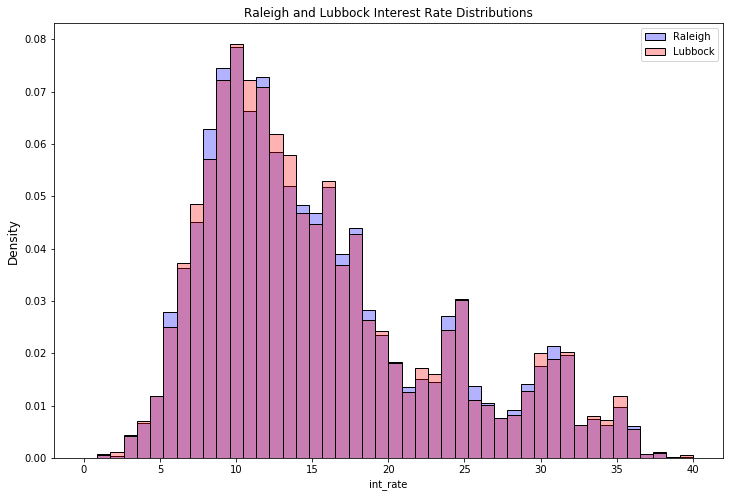

In [18]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df["int_rate"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Interest Rate Distributions")
sns.histplot(merge_raleigh_df, x="int_rate", stat='density', bins=bins_num_raleigh, binrange=(0, 40), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df, x="int_rate", stat='density', bins=bins_num_raleigh, binrange=(0, 40), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);

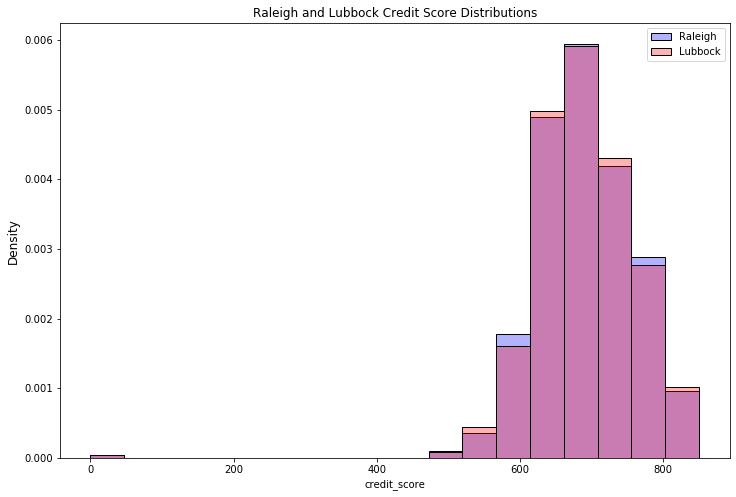

In [19]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df["credit_score"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Credit Score Distributions")
sns.histplot(merge_raleigh_df, x="credit_score", stat='density', bins=bins_num_raleigh, binrange=(0, 850), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df, x="credit_score", stat='density', bins=bins_num_raleigh, binrange=(0, 850), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);

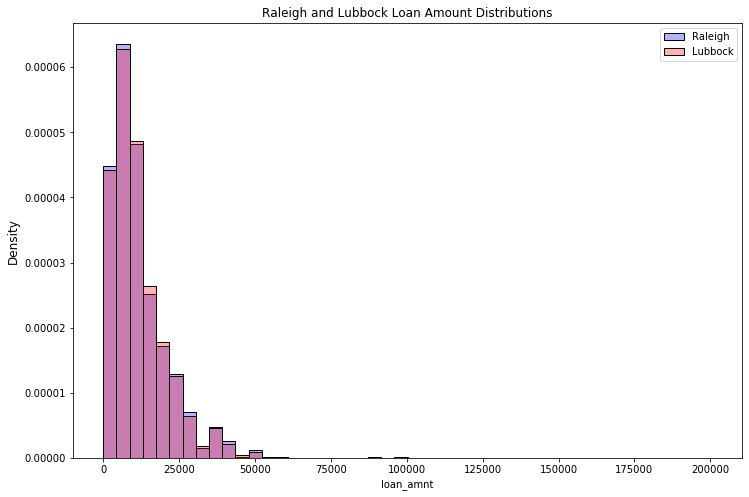

In [20]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df["loan_amnt"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Loan Amount Distributions")
sns.histplot(merge_raleigh_df, x="loan_amnt", stat='density', bins=bins_num_raleigh, binrange=(0, 200500), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df, x="loan_amnt", stat='density', bins=bins_num_raleigh, binrange=(0, 200500), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);

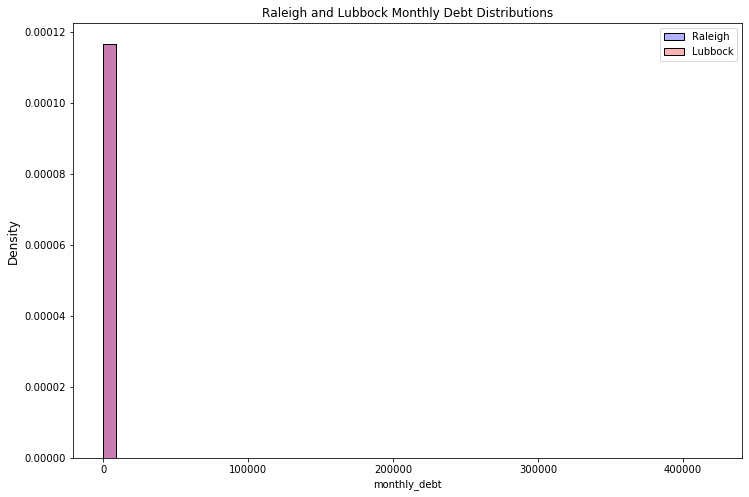

In [21]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df["monthly_debt"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Monthly Debt Distributions")
sns.histplot(merge_raleigh_df, x="monthly_debt", stat='density', bins=bins_num_raleigh, binrange=(0, 420000), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df, x="monthly_debt", stat='density', bins=bins_num_raleigh, binrange=(0, 420000), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);

As you probably noticed, some borrowers have credit score values of 0. This can't be true, because credit score ranges from 350 to 850. Fix this by replacing these values with np.nan. Recreate the histograms after doing so, to make sure that they distributions still look the same.

In [22]:
f"Percentage of non valid credit scores in Raleigh - {(merge_raleigh_df['credit_score'] < 300).mean():.2%}"

'Percentage of non valid credit scores in Raleigh - 0.22%'

In [23]:
f"Percentage of non valid credit scores in Lubbock - {(merge_lubbock_df['credit_score'] < 300).mean():.2%}"

'Percentage of non valid credit scores in Lubbock - 0.21%'

In [24]:
merge_raleigh_df.loc[merge_raleigh_df['credit_score'] < 300, 'credit_score'] = np.nan
merge_lubbock_df.loc[merge_lubbock_df['credit_score'] < 300, 'credit_score'] = np.nan


In [25]:
merge_raleigh_df['credit_score'].describe()

count    8773.000000
mean      691.307193
std        64.381969
min       455.000000
25%       646.000000
50%       688.000000
75%       735.000000
max       845.000000
Name: credit_score, dtype: float64

In [26]:
merge_lubbock_df['credit_score'].describe()

count    11296.000000
mean       691.491413
std         64.383539
min        431.000000
25%        646.000000
50%        689.000000
75%        735.000000
max        849.000000
Name: credit_score, dtype: float64

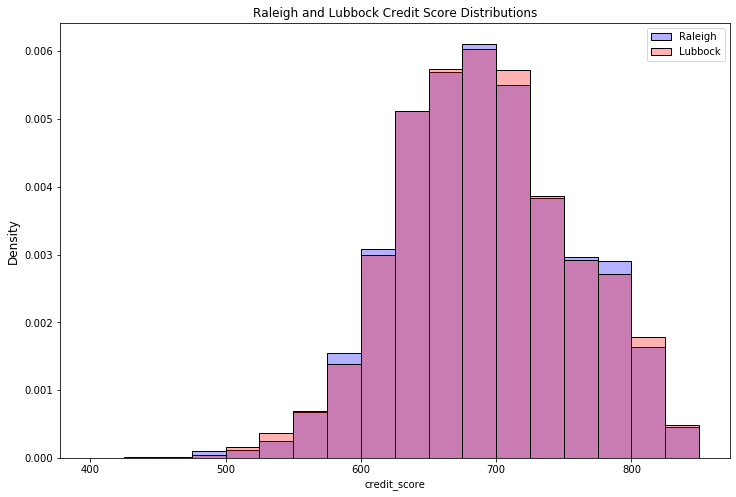

In [27]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df["credit_score"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Credit Score Distributions")
sns.histplot(merge_raleigh_df, x="credit_score", stat='density', bins=bins_num_raleigh, binrange=(400, 850), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df, x="credit_score", stat='density', bins=bins_num_raleigh, binrange=(400, 850), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);


<font color='navy'> We will also re-plot the loan amount histogram, bounding the loan amount maximum to X

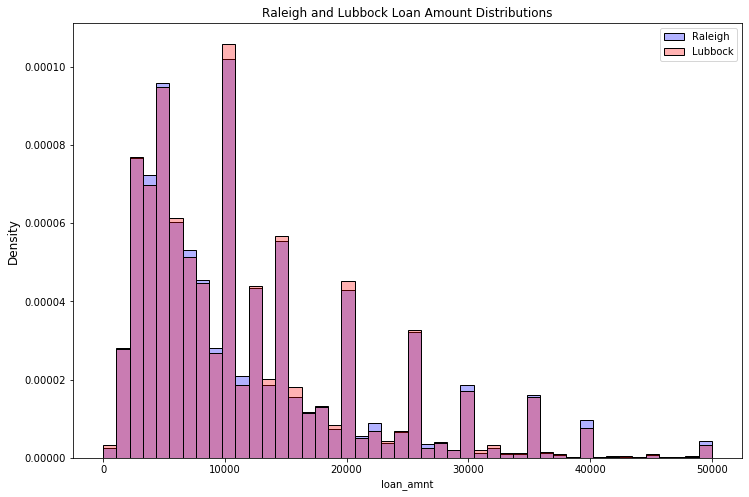

In [28]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df["loan_amnt"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Loan Amount Distributions")
sns.histplot(merge_raleigh_df, x="loan_amnt", stat='density', bins=bins_num_raleigh, binrange=(0, 50000), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df, x="loan_amnt", stat='density', bins=bins_num_raleigh, binrange=(0, 50000), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);

<font color='navy'> And again for the monthly debt:

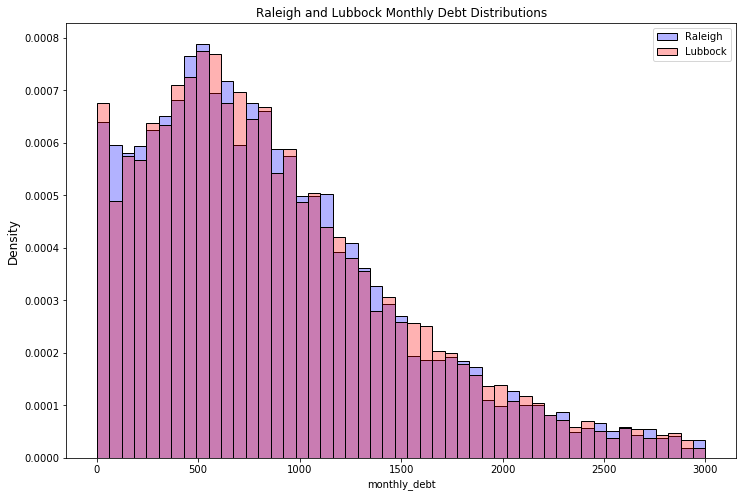

In [29]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df["monthly_debt"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Monthly Debt Distributions")
sns.histplot(merge_raleigh_df, x="monthly_debt", stat='density', bins=bins_num_raleigh, binrange=(0, 3000), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df, x="monthly_debt", stat='density', bins=bins_num_raleigh, binrange=(0, 3000), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);

<font color='navy'> We can see clearly from the graphs that both of the datasets are similary distributed On the important numeric columns we've checked!

Another method for comparing the distributions of two columns is by using a [q-q-plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). Repeat the comparisons of the above 5 features by creating the corresponding q-q-plots. You can either use the `seaborn_qqplot` package or [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot_2samples.html)'s implemetation, or write your own function that creates this plot. 

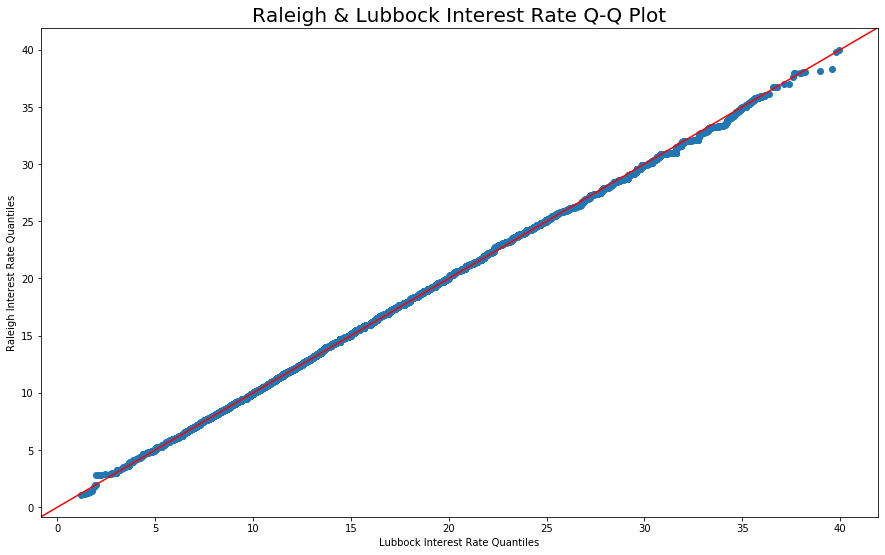

In [30]:
fig = qqplot_2samples(merge_lubbock_df["int_rate"],
                      merge_raleigh_df["int_rate"],
                      ylabel="Raleigh Interest Rate Quantiles",
                      xlabel="Lubbock Interest Rate Quantiles",
                     line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh & Lubbock Interest Rate Q-Q Plot", size=20);

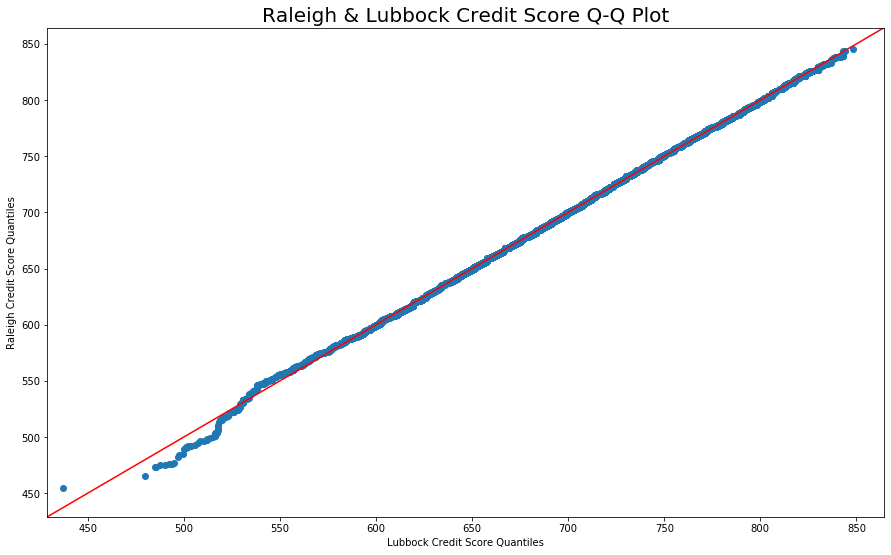

In [31]:
fig = qqplot_2samples(merge_lubbock_df["credit_score"],
                      merge_raleigh_df["credit_score"],
                      ylabel="Raleigh Credit Score Quantiles",
                      xlabel="Lubbock Credit Score Quantiles",
                     line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh & Lubbock Credit Score Q-Q Plot", size=20);

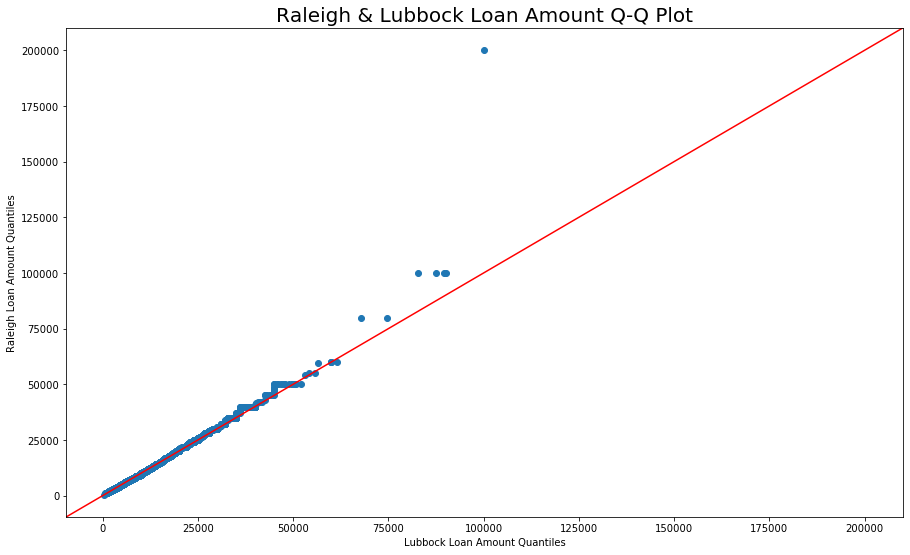

In [32]:
fig = qqplot_2samples(merge_lubbock_df["loan_amnt"],
                      merge_raleigh_df["loan_amnt"],
                      ylabel="Raleigh Loan Amount Quantiles",
                      xlabel="Lubbock Loan Amount Quantiles",
                     line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh & Lubbock Loan Amount Q-Q Plot", size=20);

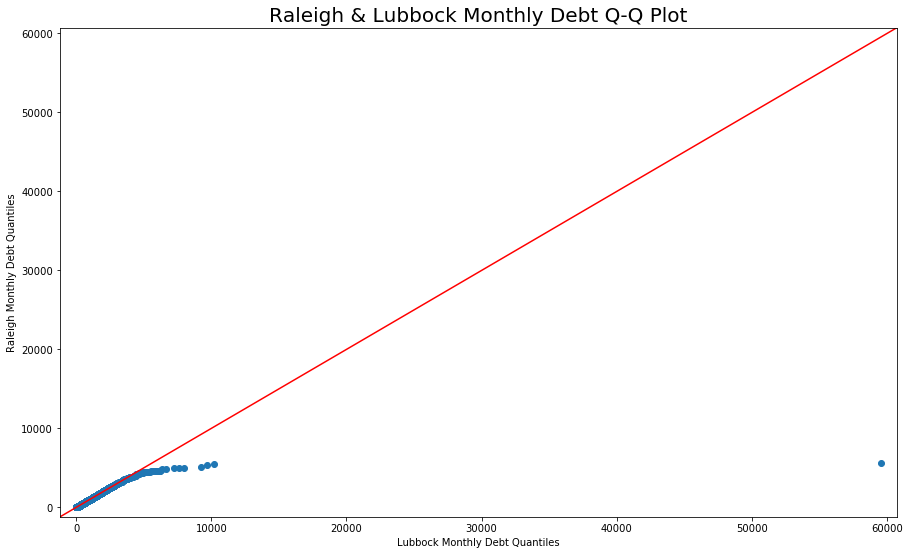

In [33]:
fig = qqplot_2samples(merge_lubbock_df["monthly_debt"],
                      merge_raleigh_df["monthly_debt"],
                      ylabel="Raleigh Monthly Debt Quantiles",
                      xlabel="Lubbock Monthly Debt Quantiles",
                     line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh & Lubbock Monthly Debt Q-Q Plot", size=20);

<font color='navy'> Except for 'tails' in either ends of the graphs, the distributions seems similar.

This method is also commonly used for visually comparing an observed distribution with a theoretical one (e.g. checking whether the values of a given column are normally distributed). One implementation is the [statsmodels.graphics.gofplots.qqplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html) package which allows you to compare a given array with various distributions. 

Use this package to compare the distribution of credit score and interest rate in both town with a normal distribution.

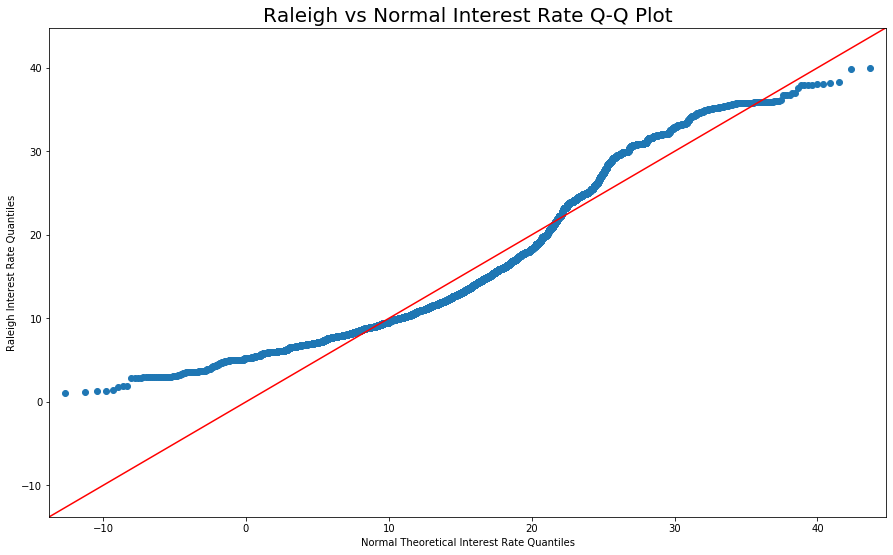

In [34]:
fig = qqplot(merge_raleigh_df["int_rate"],
             loc=merge_raleigh_df["int_rate"].mean(),
             scale=merge_raleigh_df["int_rate"].std(),
             ylabel="Raleigh Interest Rate Quantiles",
             xlabel="Normal Theoretical Interest Rate Quantiles",
             line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh vs Normal Interest Rate Q-Q Plot", size=20);

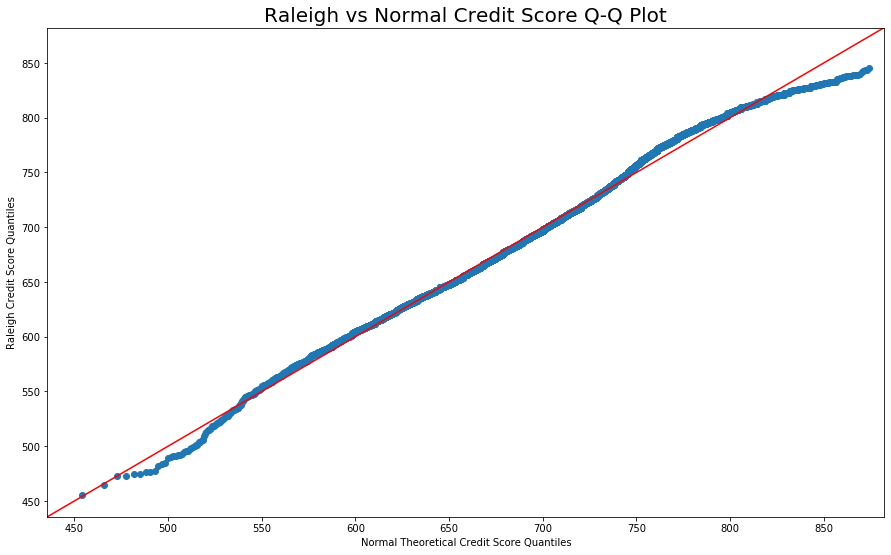

In [35]:
fig = qqplot(merge_raleigh_df["credit_score"],
             loc=merge_raleigh_df["credit_score"].mean(),
             scale=merge_raleigh_df["credit_score"].std(),
             ylabel="Raleigh Credit Score Quantiles",
             xlabel="Normal Theoretical Credit Score Quantiles",
             line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh vs Normal Credit Score Q-Q Plot", size=20);

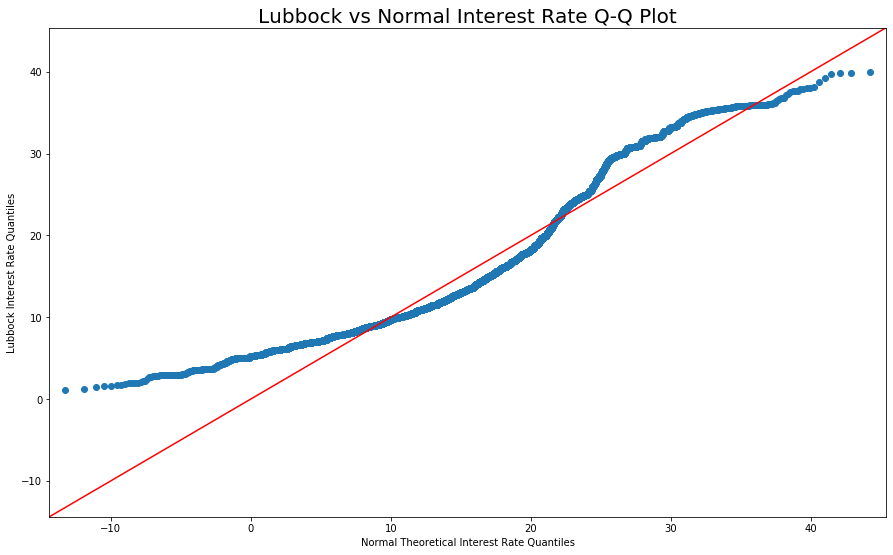

In [36]:
fig = qqplot(merge_lubbock_df["int_rate"],
             loc=merge_lubbock_df["int_rate"].mean(),
             scale=merge_lubbock_df["int_rate"].std(),
             ylabel="Lubbock Interest Rate Quantiles",
             xlabel="Normal Theoretical Interest Rate Quantiles",
             line="45");
fig.set_size_inches((15, 9))
plt.title("Lubbock vs Normal Interest Rate Q-Q Plot", size=20);

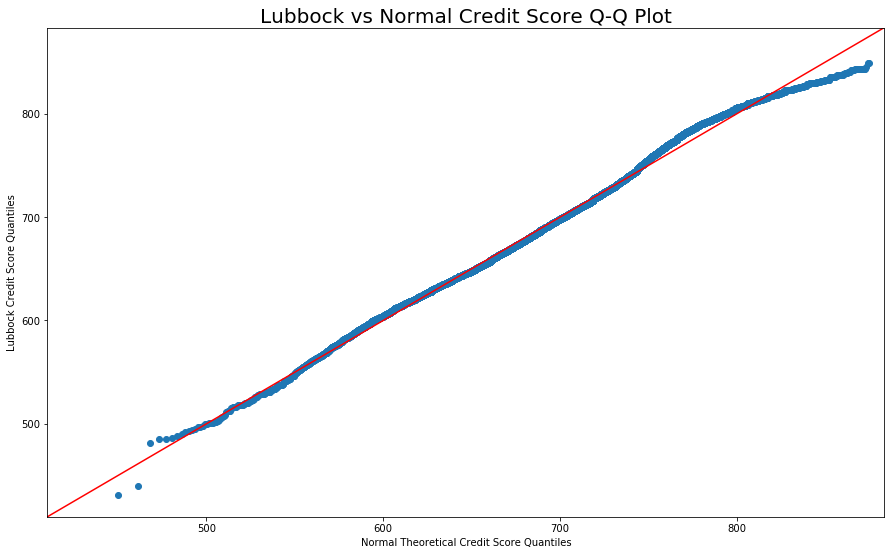

In [37]:
fig = qqplot(merge_lubbock_df["credit_score"],
             loc=merge_lubbock_df["credit_score"].mean(),
             scale=merge_lubbock_df["credit_score"].std(),
             ylabel="Lubbock Credit Score Quantiles",
             xlabel="Normal Theoretical Credit Score Quantiles",
             line="45");
fig.set_size_inches((15, 9))
plt.title("Lubbock vs Normal Credit Score Q-Q Plot", size=20);

<font color='navy'> When comparing to the Normal distribution with the samples means and samples stds, we can't see a good fit for the interes rate, but the credit score does seem like a good fit with the distibution.

## Comparing activated populations 

Redo the above comparisons only for borrowes in Raleigh and Lubbock which accepted their loan offers

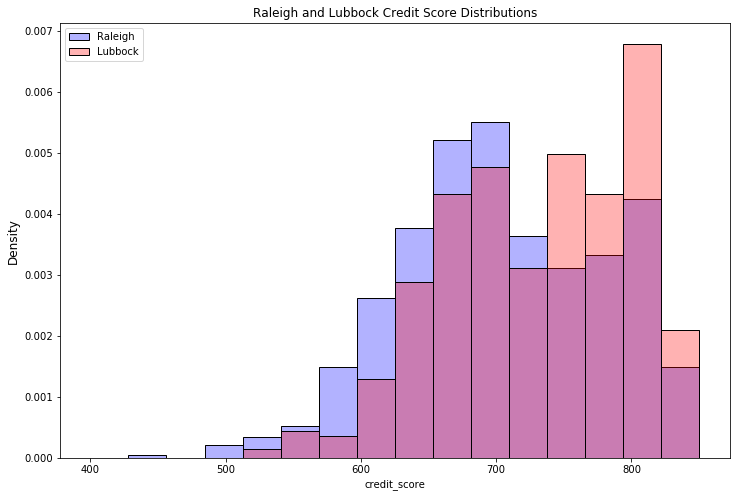

In [38]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "credit_score"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Credit Score Distributions")
sns.histplot(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted']], x="credit_score", stat='density', bins=bins_num_raleigh, binrange=(400, 850), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted']], x="credit_score", stat='density', bins=bins_num_raleigh, binrange=(400, 850), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);


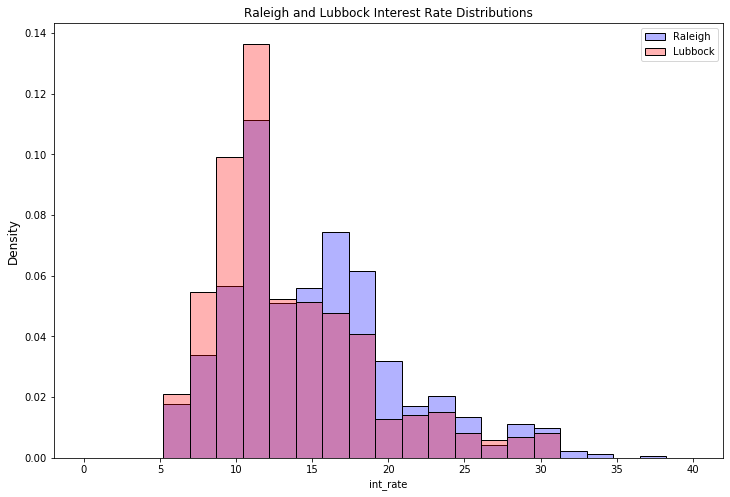

In [39]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "int_rate"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Interest Rate Distributions")
sns.histplot(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted']], x="int_rate", stat='density', bins=bins_num_raleigh, binrange=(0, 40), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted']], x="int_rate", stat='density', bins=bins_num_raleigh, binrange=(0, 40), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);


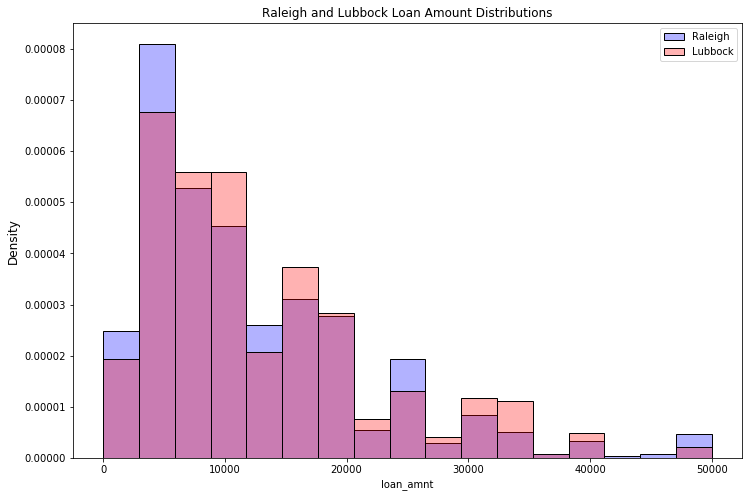

In [40]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "loan_amnt"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Loan Amount Distributions")
sns.histplot(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted']], x="loan_amnt", stat='density', bins=bins_num_raleigh, binrange=(0, 50000), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted']], x="loan_amnt", stat='density', bins=bins_num_raleigh, binrange=(0, 50000), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);


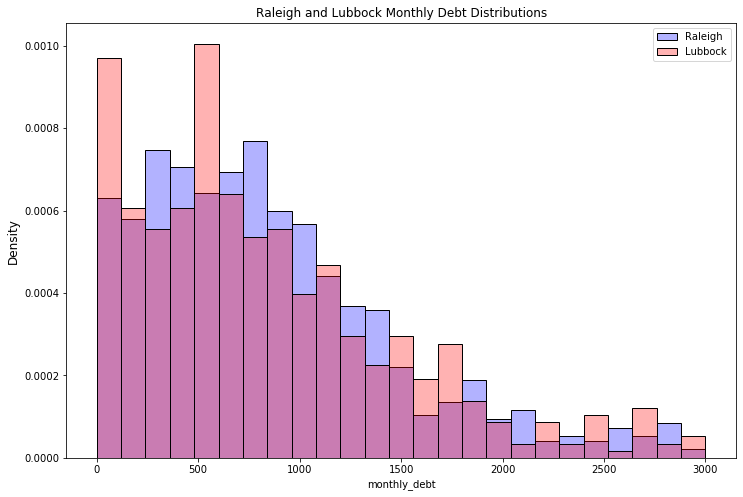

In [41]:
bins_num_raleigh = int(np.sqrt(len(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "monthly_debt"].unique())))

plt.figure(figsize=(12, 8))
plt.title("Raleigh and Lubbock Monthly Debt Distributions")
sns.histplot(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted']], x="monthly_debt", stat='density', bins=bins_num_raleigh, binrange=(0, 3000), label='Raleigh', color='b', alpha=0.3)
sns.histplot(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted']], x="monthly_debt", stat='density', bins=bins_num_raleigh, binrange=(0, 3000), label='Lubbock', color='r', alpha=0.3)
plt.legend()
plt.ylabel('Density', fontsize=12);


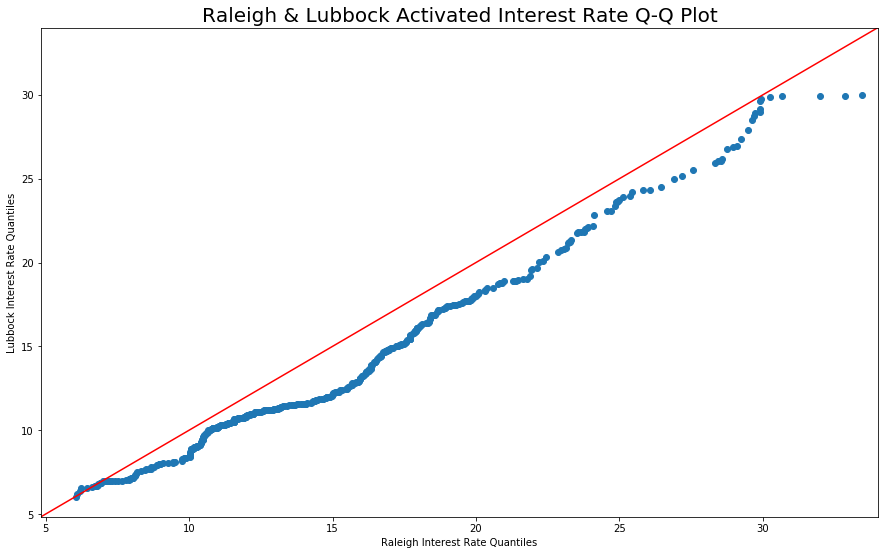

In [42]:
fig = qqplot_2samples(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "int_rate"],
                      merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "int_rate"],
                      ylabel="Raleigh Interest Rate Quantiles",
                      xlabel="Lubbock Interest Rate Quantiles",
                     line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh & Lubbock Activated Interest Rate Q-Q Plot", size=20);

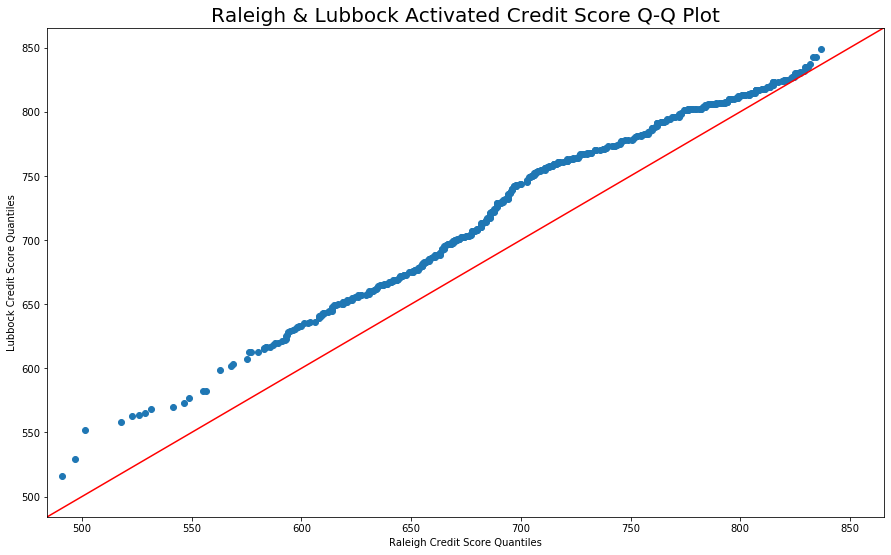

In [43]:
fig = qqplot_2samples(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "credit_score"],
                      merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "credit_score"],
                      ylabel="Raleigh Credit Score Quantiles",
                      xlabel="Lubbock Credit Score Quantiles",
                     line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh & Lubbock Activated Credit Score Q-Q Plot", size=20);

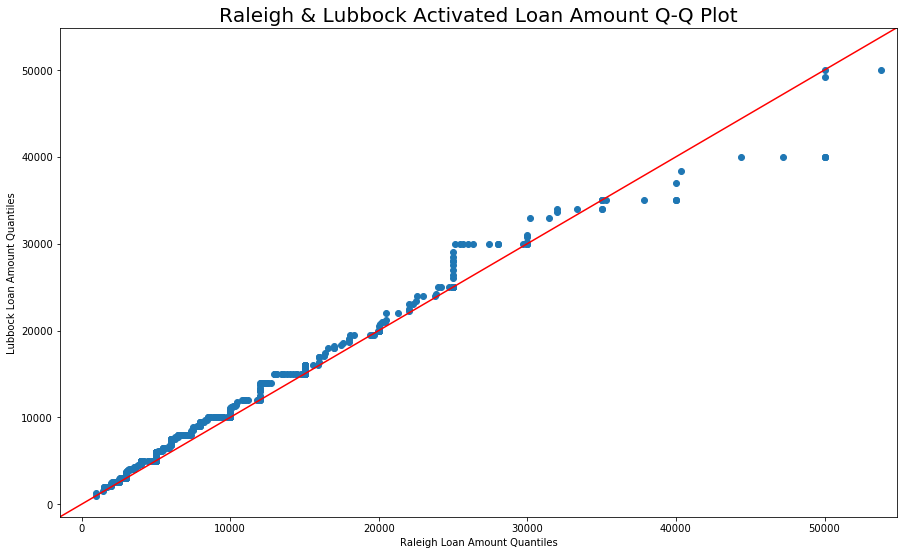

In [44]:
fig = qqplot_2samples(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "loan_amnt"],
                      merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "loan_amnt"],
                      ylabel="Raleigh Loan Amount Quantiles",
                      xlabel="Lubbock Loan Amount Quantiles",
                     line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh & Lubbock Activated Loan Amount Q-Q Plot", size=20);

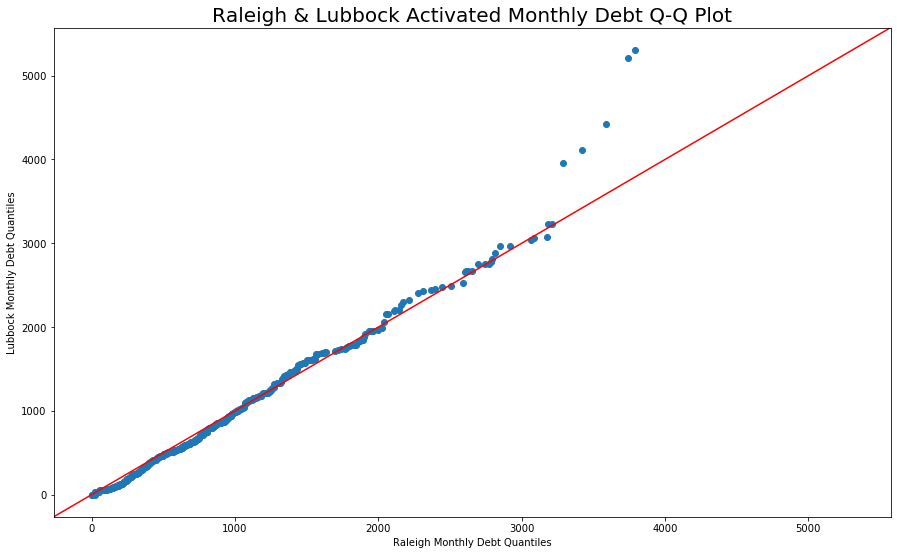

In [45]:
fig = qqplot_2samples(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "monthly_debt"],
                      merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "monthly_debt"],
                      ylabel="Raleigh Monthly Debt Quantiles",
                      xlabel="Lubbock Monthly Debt Quantiles",
                     line="45");
fig.set_size_inches((15, 9))
plt.title("Raleigh & Lubbock Activated Monthly Debt Q-Q Plot", size=20);

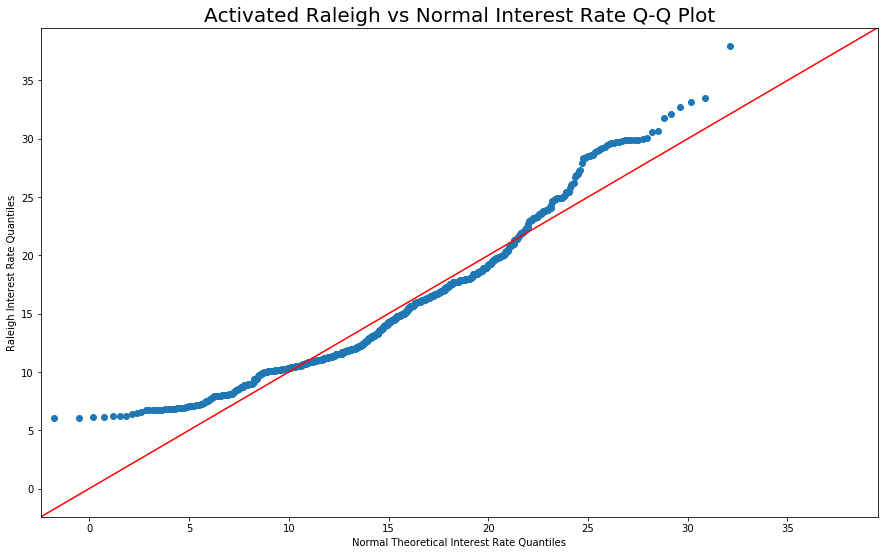

In [46]:
fig = qqplot(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "int_rate"],
             loc=merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "int_rate"].mean(),
             scale=merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "int_rate"].std(),
             ylabel="Raleigh Interest Rate Quantiles",
             xlabel="Normal Theoretical Interest Rate Quantiles",
             line="45");
fig.set_size_inches((15, 9))
plt.title("Activated Raleigh vs Normal Interest Rate Q-Q Plot", size=20);

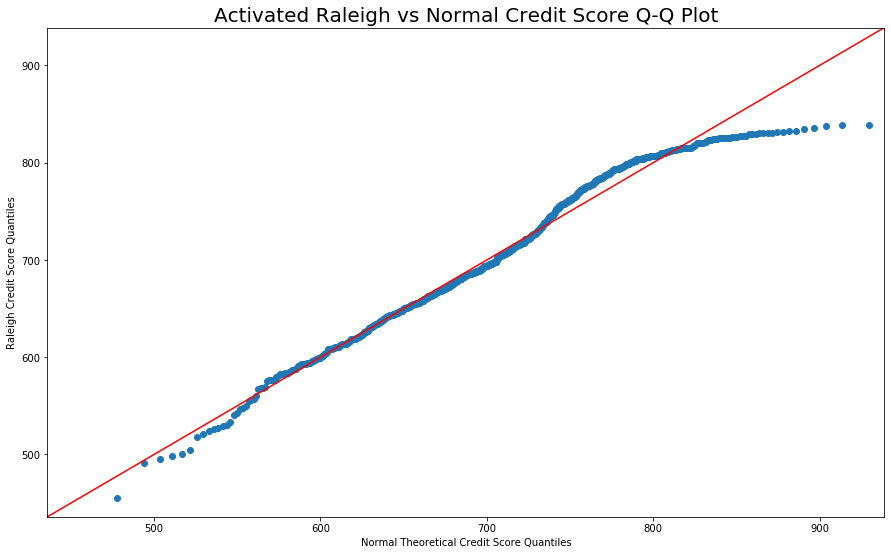

In [47]:
fig = qqplot(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "credit_score"],
             loc=merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "credit_score"].mean(),
             scale=merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "credit_score"].std(),
             ylabel="Raleigh Credit Score Quantiles",
             xlabel="Normal Theoretical Credit Score Quantiles",
             line="45");
fig.set_size_inches((15, 9))
plt.title("Activated Raleigh vs Normal Credit Score Q-Q Plot", size=20);

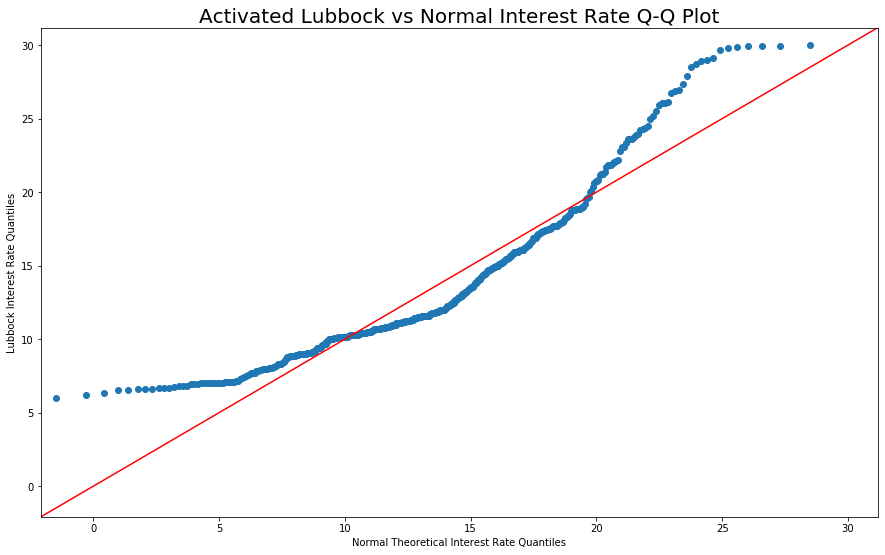

In [48]:
fig = qqplot(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "int_rate"],
             loc=merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "int_rate"].mean(),
             scale=merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "int_rate"].std(),
             ylabel="Lubbock Interest Rate Quantiles",
             xlabel="Normal Theoretical Interest Rate Quantiles",
             line="45");
fig.set_size_inches((15, 9))
plt.title("Activated Lubbock vs Normal Interest Rate Q-Q Plot", size=20);

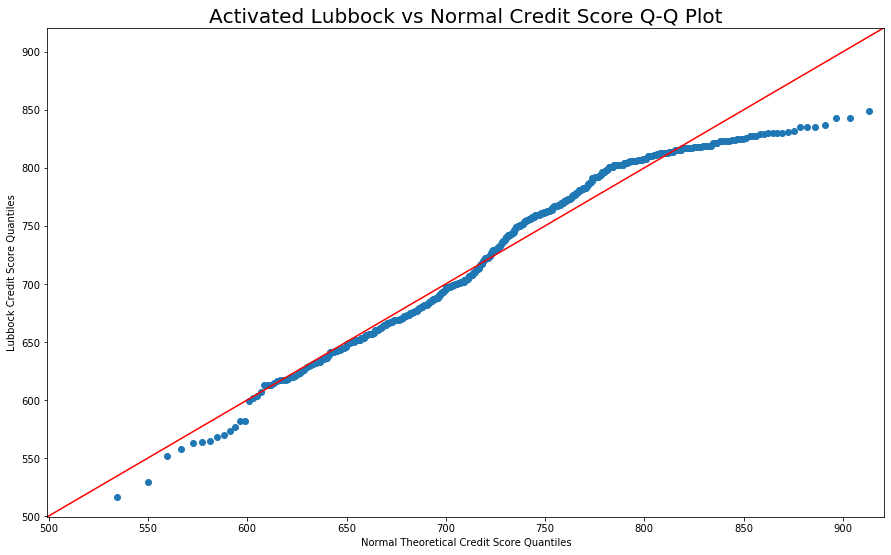

In [49]:
fig = qqplot(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "credit_score"],
             loc=merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "credit_score"].mean(),
             scale=merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "credit_score"].std(),
             ylabel="Lubbock Credit Score Quantiles",
             xlabel="Normal Theoretical Credit Score Quantiles",
             line="45");
fig.set_size_inches((15, 9))
plt.title("Activated Lubbock vs Normal Credit Score Q-Q Plot", size=20);

So it seems that there are some differences between the two populations. Let's visualizes this using a KDE (kernel density estimation) smoothening. This is implemented (with Gaussian kernel), for example, in the [`seaborn.distplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html) package, using the `kde=True` flag. Use this package to compare the distributions of `credit_score` and `int_rate` in the activated populations in Raleigh and Luboock. What do you observe?

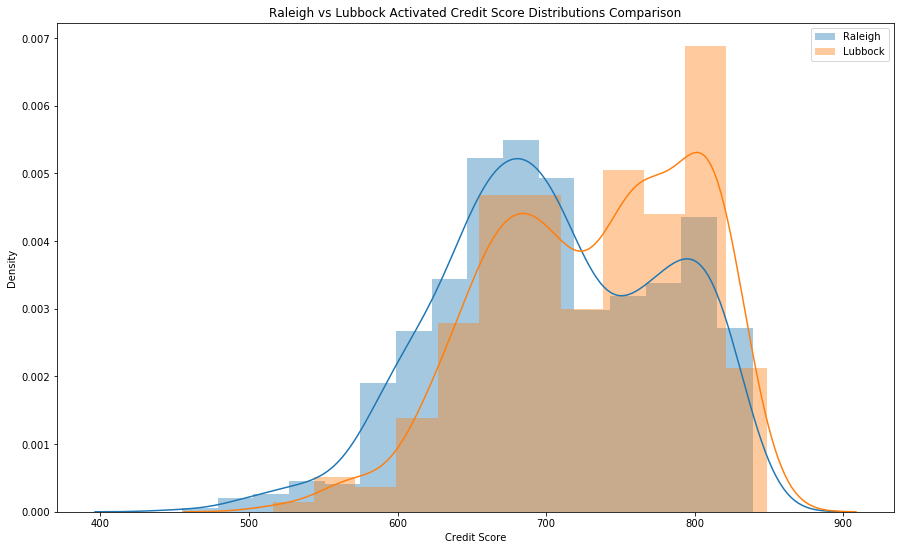

In [50]:
plt.figure(figsize=(15,9))
sns.distplot(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "credit_score"], kde=True, label="Raleigh")
sns.distplot(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "credit_score"], kde=True, label="Lubbock")
plt.legend()
plt.xlabel("Credit Score")
plt.title("Raleigh vs Lubbock Activated Credit Score Distributions Comparison");

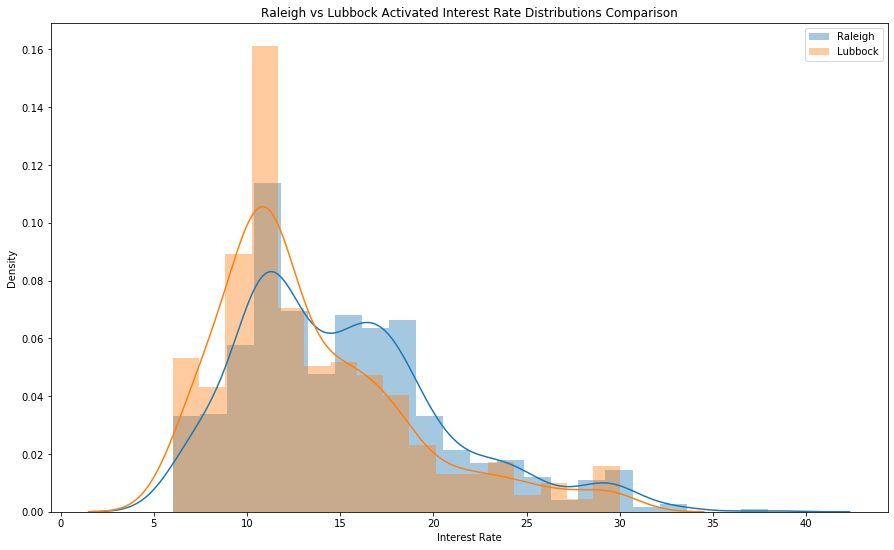

In [51]:
plt.figure(figsize=(15,9))
sns.distplot(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "int_rate"], kde=True, label="Raleigh")
sns.distplot(merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "int_rate"], kde=True, label="Lubbock")
plt.legend()
plt.xlabel("Interest Rate")
plt.title("Raleigh vs Lubbock Activated Interest Rate Distributions Comparison");

<font color='navy'>
    Observing the activated populations, it seems that the populations of Raleigh and Lubbock are indeed different.<br>
    We suspect there are 2 internal populations in the data, borrowers with a low credit score and high interest rate, and borrowers with high credit score and low interest rate. <br>
    The city of Lubbock has a larger proportion of the high credit score borrowers, hence also of the low interest rate ones, in contrast, the city of Raleigh, where the flyer program was deployed, contains a larger proportion of the low credit score borrowers with the high interest rate.

## Checking goodness of fit of the two distributions 

The question of whether the two activated populations are drawn from the same borrower population can also be tested using the Kolmogorov-Smirnov test. Setting your confidence level at 5%, and using the [scipy.stats.ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) package, formulate and perform a two-sample Kolmogorov-Smirnov test to check if the activated populations in Raleigh and Lubbock differ in terms of credit score.

In [52]:
_, p_value = ks_2samp(merge_raleigh_df.loc[merge_raleigh_df['offer_accepted'], "credit_score"], merge_lubbock_df.loc[merge_lubbock_df['offer_accepted'], "credit_score"])
alpha = 0.05

In [53]:
if p_value < alpha:
    print("We can reject the null hypothesis")
else:
    print("We cannot reject the null hypothesis")

We can reject the null hypothesis


<font color='navy'>
    We rejected the null hypothesis that the two distributions are drawn from the same population, meaning the distributions are different.

## Soft clustering for detecting risk sub-populations

As you may have noted, for both credit score and interest rate, the distribution of values in Raleigh and Lubbock goes from being unimodal, for the general population, to bimodal, for the activated population. This is a commonly observed phenomenon and there are many speculations about why this happens. One possibility, is that the distribution of values in the activated population is in fact a mixture of two distinct borrower populations (e.g. risky and non-risky).

In this section we will use a Gaussian [mixture-model](https://en.wikipedia.org/wiki/Mixture_model) (GMM), which is a soft clustering model, in order to try to detect the existence of two borrower populations in among activated loans.

_Remark_: While credit score and offered interest rate are generally fair indicators of the risk of a loan, using them as markers for the risk of a loan is very simplistic and should not be done beyond exploratory analyses.

In fit to apply a mixture model to our data, we will use the [`sklearn.mixture.GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) package. Import this package.

In [54]:
from sklearn.mixture import GaussianMixture

Do the following:
* Initiate an instance of `GaussianMixture`
* Create the training dataset, which comprises of two columns of all credit scores and interest rates of **activated loans** in Lubbock **and** Raleigh, each row corresponding to a single loan
* fit your `GaussianMixture` instance to this data to detect a 2-component mixture

Refer to the packages [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) if you run into any trouble.

In [55]:
gm = GaussianMixture(2)

In [56]:
gm_training_data = pd.concat([merge_raleigh_df[merge_raleigh_df["offer_accepted"]][["int_rate", "credit_score"]],
                              merge_lubbock_df[merge_lubbock_df["offer_accepted"]][["int_rate", "credit_score"]]])

In [57]:
gm_training_data.head()

,int_rate,credit_score
3,12.94,711.0
11,6.71,833.0
14,16.69,694.0
15,10.87,742.0
25,17.27,656.0


In [58]:
gm_training_data.isna().sum()

int_rate        0
credit_score    1
dtype: int64

In [59]:
gm.fit(gm_training_data.dropna())

GaussianMixture(n_components=2)

Look at the center points of the two distributions you detected (using the packages `means_` attribute). Do the means of the distribution corroborate the hypothesis that the population correspond to different risk groups? (recall- higher risk borrowers tend to have lower credit scores and be offered higher interest rates).

In [60]:
gm.means_

array([[ 20.56399451, 646.64095475],
       [ 11.75523794, 745.40792113]])

<font color='navy'>
    We can see two clusters, corresponding to our suspicions above, one having a higher credit score and lower interest rate (lower risk), the other having a lower credit score and higher interest rate (higher risk).

Use your `GaussianMixture` instance to classify the activated population in Raleigh into two joint credit score-interest rate distributions. Create a scatter plot describing the credit score and interest rate of **all** loan offers in Raleigh, in which non-activated loans are colored  in one color, and the point representing activated loans are colored according to the distribution they are drawn from.

_Remark_: Since this plot would have a very large number of points, it might be a good idea to play with the values of `alpha` and `s`, so that the different groups would be more apparent.

In [61]:
raleigh_scatter_df = merge_raleigh_df[["int_rate", "credit_score"]]
raleigh_scatter_df["class"] = 2
raleigh_scatter_df.loc[merge_raleigh_df["offer_accepted"], "class"] = gm.predict(raleigh_scatter_df[merge_raleigh_df["offer_accepted"]][["int_rate", "credit_score"]])

In [62]:
raleigh_scatter_df.head()

,int_rate,credit_score,class
0,11.97,776.0,2
1,24.37,647.0,2
2,30.32,603.0,2
3,12.94,711.0,1
4,16.89,637.0,2


In [63]:
raleigh_scatter_df["class"].value_counts()

2    7980
1     529
0     283
Name: class, dtype: int64

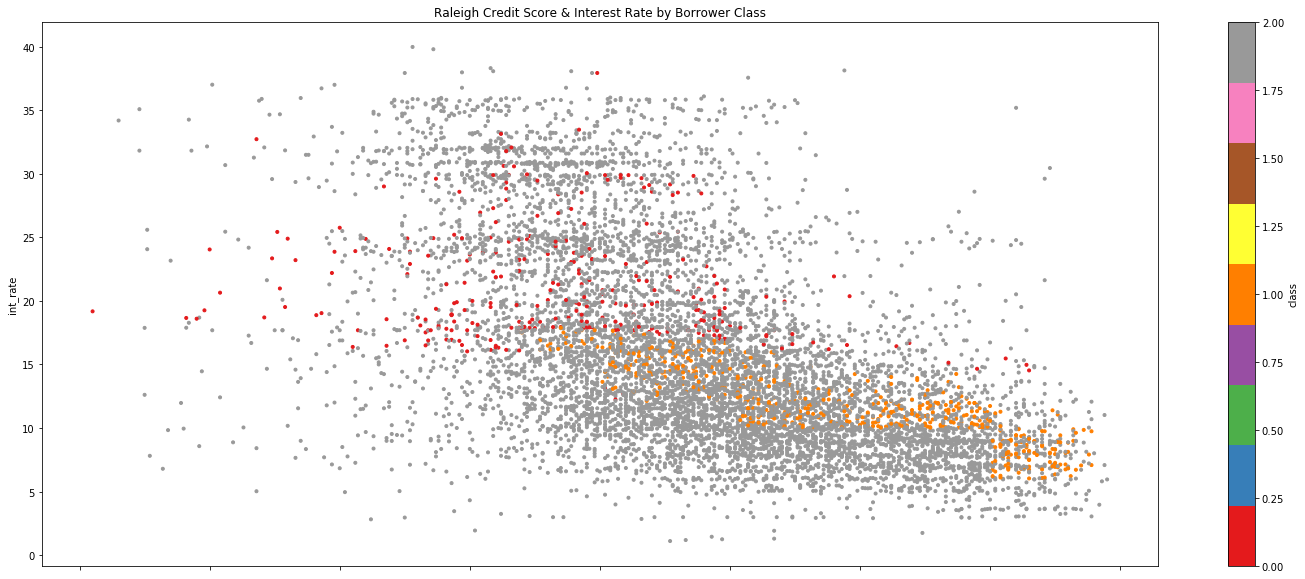

In [64]:
raleigh_scatter_df.plot.scatter(x= "credit_score", y= "int_rate", c= "class", colormap='Set1', alpha=1, s=9, figsize=(25, 10), title="Raleigh Credit Score & Interest Rate by Borrower Class");

Create the same scatterplot for the Lubbock table. Can you detect any differences between the two plots visually?

In [65]:
lubbock_scatter_df = merge_lubbock_df[["int_rate", "credit_score"]].dropna()
lubbock_scatter_df["class"] = 2
lubbock_scatter_df.loc[merge_lubbock_df["offer_accepted"], "class"] = gm.predict(lubbock_scatter_df[merge_lubbock_df["offer_accepted"]][["int_rate", "credit_score"]])

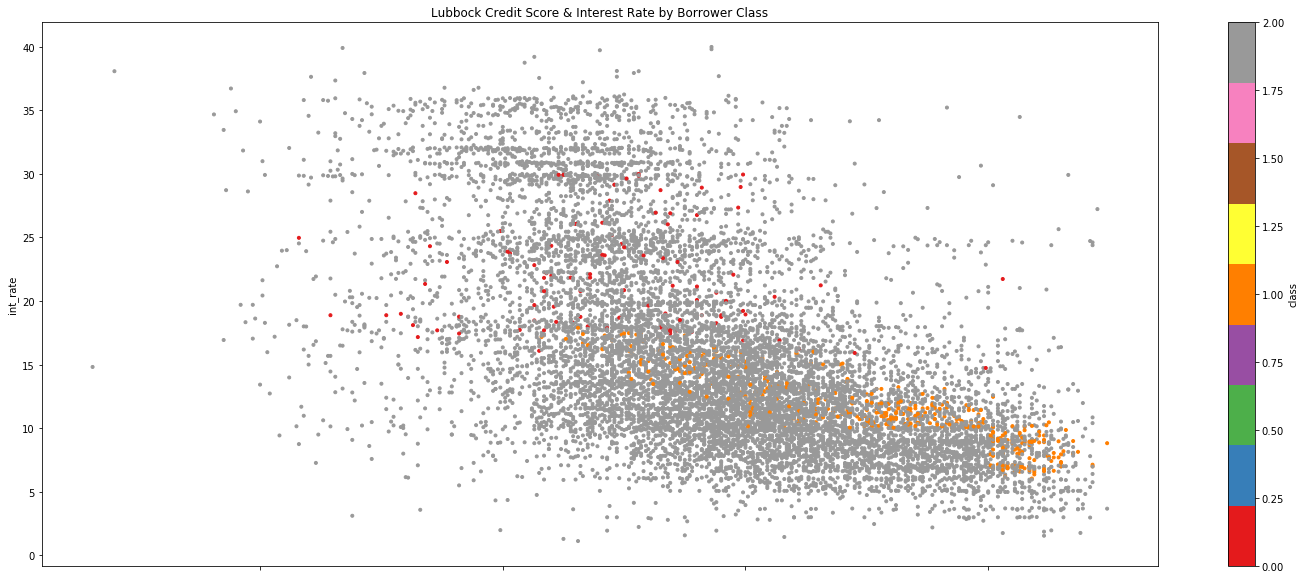

In [66]:
lubbock_scatter_df.plot.scatter(x= "credit_score", y= "int_rate", c= "class", colormap='Set1', alpha=1, s=9, figsize=(25, 10), title="Lubbock Credit Score & Interest Rate by Borrower Class");

<font color='navy'>We can see that in the Raleigh's scatterplot, there are more orange dots - representing the 'high risk' cluster (lower credit score, higher interest rate)

\* **Bonus** 

# Infrernce from a regression model

So far, our analysis of risk groups has been exploratory and did not include any computation of return or actual assesment of the risk of a group. Also, our partition of the data into two risk groups was partially based on credit scores, which are imperfect predictors of the risk of a loan. 

In this section, we will attempt a more analytic approach to classifying risk populations. Before starting our analysis, we should decide on a criterion for a sub-population to be riskier than another. Throughout this section, we will use the sub-population's portfolio's yield as this criterion; that is- we'll consider one sub-population as riskier than another if the former's portfolio has a significantly lower yield than the latter.

## Comparing high-risk and low-risk subgroups

To begin with, we need to decide on our classification of high-risk and low-risk subgroups. In the previous section we relied on the borrowers' credit scores and offered interest rates for clasifying these subgroups; however, these metrics have some obvious problems. For example, many borrowers have no credit scores, and could not be classified using it. Also, interest rate not a direct assessment of the risk level of the client, but rather a reflection of the risk assessed by the issuing company.

Instead, we'll attempt to use an internally developed charge-off (CO) classifier, called the `PPCC21 model`. This model is a machine learning model, which attempts to predict whether a given loan is likely to default (or, synonymously- charge off). Since a charge-off event has a very negative effect on the yield of a portfolio, we will consider the predicted CO population as the high-risk group and non-CO population as the low-risk population. However, this statement is not clear-cut and needs to be tested.

### Analyzing historic payments data

In this section, we will test our hypothesis that CO populations are significantly riskier (and therefore produce significantly lower yields) than no-CO population. In order to do so, we will need complete payments data from historic loans. Let's start by uploading our data. 

In the following path, you will find payment records on ~470,000 loans from 2017Q2.

In [67]:
payments2017Q2=pd.read_parquet(os.path.join(ASSIGNMENT2_DATA,"TU_agg_payments.parquet")) 

The payments table contains aggregated payments; that is- the column `agg_paid{i}` contains the amount paid by the client up to the i-th month on book (MOB). Add new columns to the table (one for each mob), containing the amount paid by the client _at_ mob i.

In [68]:
payments2017Q2.head()

,account_id,co_mob,int_rate,monthly_pmt,loan_amnt,term,agg_paid1,agg_paid2,agg_paid3,agg_paid4,...,agg_paid26,agg_paid27,agg_paid28,agg_paid29,agg_paid30,agg_paid31,agg_paid32,agg_paid33,agg_paid34,agg_paid35
0,000066de88925e1fe302bc288ad33a8c0e852e74aa51fd...,NaN,17.27,125.0,5000.0,60.0,125.0,250.0,375.0,500.0,...,3249.7,6639.9,6639.9,6639.9,6639.9,6639.9,6639.9,6639.9,6639.9,6639.9
1,000067346de3d6df0d7e9248364184edd63227f50d8754...,NaN,14.32,103.0,3000.0,36.0,103.0,206.0,309.0,412.0,...,2678.0,2781.0,3655.0,3655.0,3655.0,3655.0,3655.0,3655.0,3655.0,3655.0
2,0000c634b1c49508ee3344d64fbe9560970d42ff6cdf8d...,NaN,32.60,158.0,3600.0,36.0,158.0,316.0,474.0,632.0,...,4107.9,4265.9,4423.9,5546.4,5546.4,5546.4,5546.4,5546.4,5546.4,5546.4
3,0000c95ea96bc86565526c262eaba3b7f69f9ae024ea98...,NaN,18.41,392.0,15300.0,60.0,391.9,783.9,1175.8,1567.8,...,19845.5,19845.5,19845.5,19845.5,19845.5,19845.5,19845.5,19845.5,19845.5,19845.5
4,0000e23adbe7162ac902b6fe44e6876d9106a13ad4b09a...,NaN,13.63,136.0,4000.0,36.0,136.0,272.0,408.0,544.0,...,4624.2,4624.2,4624.2,4624.2,4624.2,4624.2,4624.2,4624.2,4624.2,4624.2


In [69]:
agg_cols = [f"agg_paid{i}" for i in range(1, 36)]
paid_cols = [f"paid{i}" for i in range(2, 36)]

payments2017Q2['paid1'] = payments2017Q2['agg_paid1']
payments2017Q2[paid_cols] = payments2017Q2[agg_cols[1:]].values - payments2017Q2[agg_cols[:-1]].values


In [70]:
payments2017Q2[['paid1'] + paid_cols].head()

,paid1,paid2,paid3,paid4,paid5,paid6,paid7,paid8,paid9,paid10,...,paid26,paid27,paid28,paid29,paid30,paid31,paid32,paid33,paid34,paid35
0,125.0,125.0,125.0,125.0,124.9,125.0,125.0,125.0,125.0,125.0,...,125.0,3390.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,...,103.0,103.0,874.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,158.0,158.0,158.0,158.0,158.0,158.0,158.0,158.0,158.0,158.0,...,158.0,158.0,158.0,1122.5,0.0,0.0,0.0,0.0,0.0,0.0
3,391.9,392.0,391.9,392.0,391.9,391.9,392.0,391.9,392.0,391.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,136.0,136.0,136.0,136.0,136.0,136.0,135.9,136.0,136.0,136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Compute the [internal revenue rate (IRR)](https://www.investopedia.com/terms/i/irr.asp) of each loan. Use the [`numpy_financial.irr`](https://numpy.org/numpy-financial/latest/irr.html) function.

In [71]:
import numpy_financial as npf

In [72]:
payments2017Q2['irr'] = pd.concat([-payments2017Q2['loan_amnt'], payments2017Q2[['paid1'] + paid_cols]], axis=1).apply(npf.irr, axis=1)


In [73]:
payments2017Q2['irr'].head()

0    0.014392
1    0.011779
2    0.026902
3    0.015342
4    0.011358
Name: irr, dtype: float64

Are there any nan values in your irr column? Investigate these and decide how to handle them.

In [74]:
payments2017Q2['irr'].isna().sum()

399

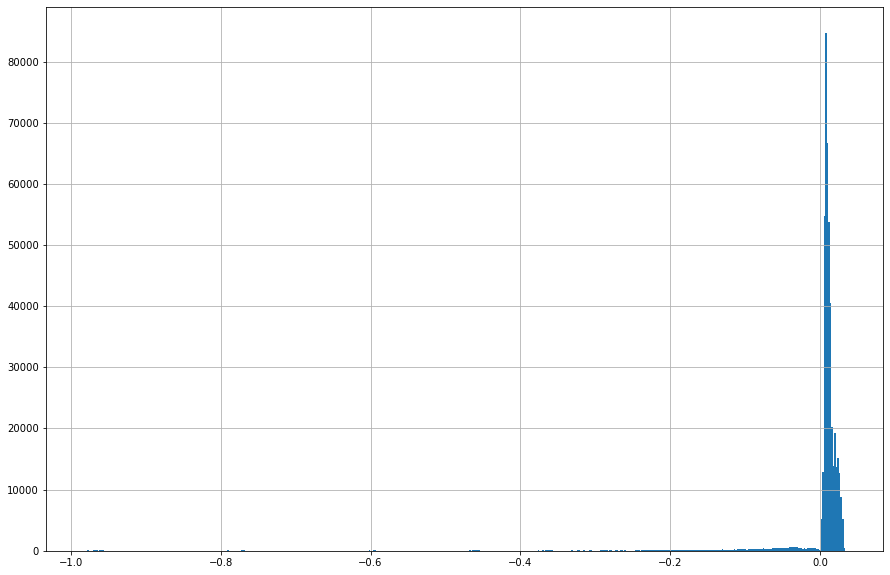

In [75]:
payments2017Q2['irr'].hist(bins=500, figsize=(15, 10));

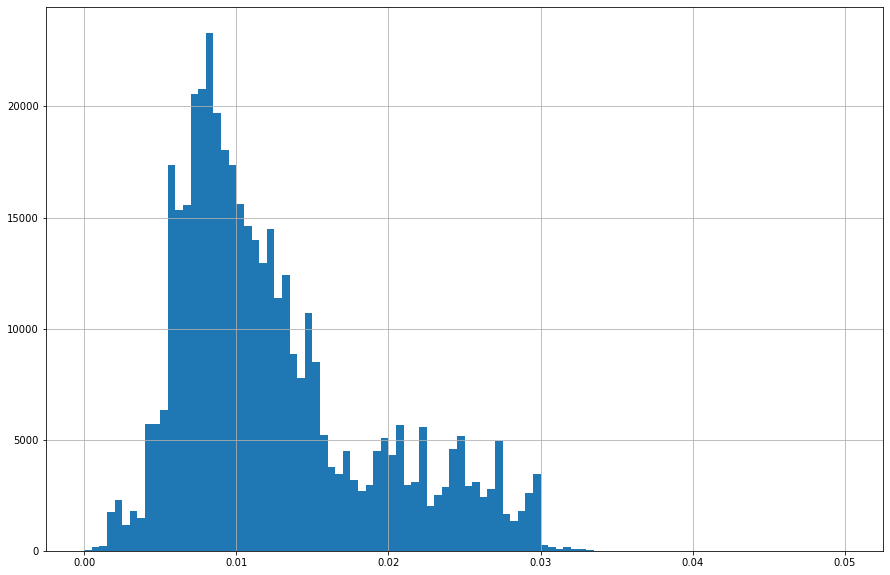

In [76]:
payments2017Q2['irr'].hist(bins=100, range=(0,0.05), figsize=(15, 10));

<span style="color:teal">Oh no! There are nans in the irr column! If we look at these lines, we'll see that these happens when no payments were made _at all_! We'll fill these nans with -1, since these mean that the loan is a loss of a 100%.
</span>

In [77]:
payments2017Q2['irr'] = payments2017Q2['irr'].fillna(-1)

In [78]:
payments2017Q2['irr'].isna().sum()

0

### Running a model

Import the PPCC21 model:

In [79]:
from pagayapro.models.PPCC21Model import PPCC21Model

The model comes trained out-of-the-box (on a set of ~160,000 loans from 2016), and has two attributes:
* `predict` - which returns T/F predictions on whether or not a loan is predicted to charge-off (True $
\iff$ loan will CO); and
* `predict_proba` - which return the predicted probability of each loan to CO and to not CO.

(it also has a `fit` attribute which we will not use). 

Both `predict` and `predict_proba` are able to predict on any dataframe with suitable features, regardless of their order or other columns in the df.

Create an instance of your model

In [80]:
model = PPCC21Model()

In order to predict whether a loan will CO or not, you will also need to add TU feature for you loans. To do so, read the 2017Q2 feature file (path below) and merge it with the payments table, to create an enriched payments table. _Note_: the merge operation may take a while. Feel free to try to improve it.

In [81]:
features2017Q2= pd.read_parquet(os.path.join(ASSIGNMENT2_DATA,"TU2017Q2_features.parquet"))

In [82]:
features2017Q2.filter(like="id").head()

,trnsid01
id,
00278de3404bece503532d9216139b4669eeb748116262a48f23f2bc7c2e7c64,0
52d75fbe844cbaf984ed84c9b18f21cf764d3b57136fc131d5362ac35617bb49,1
fa91ef4878c058464df0493fcbac4826974c45073c044dca943a8ff23532a11e,0
8d1aa11d255968f5a5ec7124b0fb87cf44e2dfb10ea62afec63b2663b085c6ea,0
1b31b0f694303d1bf6179b34f37fa6da44694d2027e60cdb3dfea2e39d233c8a,1


In [83]:
enriched_features = payments2017Q2.set_index("account_id", drop=True).join(features2017Q2.drop(columns=['int_rate', 'monthly_pmt', 'loan_amnt', 'term']))

Use the model to get a prediction for each row of your `enriched_features` dataframe.

In [84]:
enriched_features['CO_pred'] = model.predict(enriched_features)

In [85]:
enriched_features['CO_pred'].value_counts()

0    410503
1     55583
Name: CO_pred, dtype: int64

### Some model validations

Let us validate the model's accuracy. What percentage of loans in the `enriched_payments` data are charged-off? (note: a loan is COed iff it has a reported CO-mob).

In [86]:
enriched_features["co_mob"].describe()

count    38933.000000
mean        15.298539
std          7.771196
min          1.000000
25%          9.000000
50%         15.000000
75%         21.000000
max         31.000000
Name: co_mob, dtype: float64

In [87]:
f"{enriched_features['co_mob'].count() / enriched_features['co_mob'].size:.2%}"

'8.35%'

What percentage of loans are predicted to be COed by the model?

In [88]:
f"{enriched_features['CO_pred'].mean():.2%}"

'11.93%'

Use the `sklearn.metrics.accuracy_score` to get the models accuracy score.

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
accuracy_score(~enriched_features['co_mob'].isna(), enriched_features['CO_pred'])

0.8393386628218826

As you see, there is room for improvement in the model's ability to predict CO. However, there is reason to believe that it might be useful for more general risk prediction, which we will try to verify here. In what follows, we call the group the model predicted as CO by predicted-CO, and the second group by predicted-non-CO. Our criterion for the risk of a group would be a significant difference in average IRR for this group.

### Visualizing IRR

Create a scatter plot depicting the IRR of a given loan vs its interest rate, and color each group (predicted-CO and predicted-non-CO) with a different color. What phenomena can you detect from the scatterplot? 

_Note_. The IRR is given in monthly terms, while interest rate is usually given in annual term. The standard formula for passing from a mothly rate to an anuual term is
$$\text{annual rate}=\left(1+\text{monthly rate}\right)^{12}-1.$$
A very common approximation is to simply multiply the monthly rate by 12.

In [91]:
enriched_features["ann_irr"] = (1+enriched_features["irr"])**12 - 1

In [92]:
enriched_features["ann_irr"].head()

account_id
000066de88925e1fe302bc288ad33a8c0e852e74aa51fd955bd5fd9923e67e87    0.187048
000067346de3d6df0d7e9248364184edd63227f50d87549ca39299fc1482fa59    0.150871
0000c634b1c49508ee3344d64fbe9560970d42ff6cdf8d8f8d92bfe5023f0e96    0.375139
0000c95ea96bc86565526c262eaba3b7f69f9ae024ea98f5525d4ac9f188edd2    0.200458
0000e23adbe7162ac902b6fe44e6876d9106a13ad4b09a85a5b3ff437b00a52a    0.145144
Name: ann_irr, dtype: float64

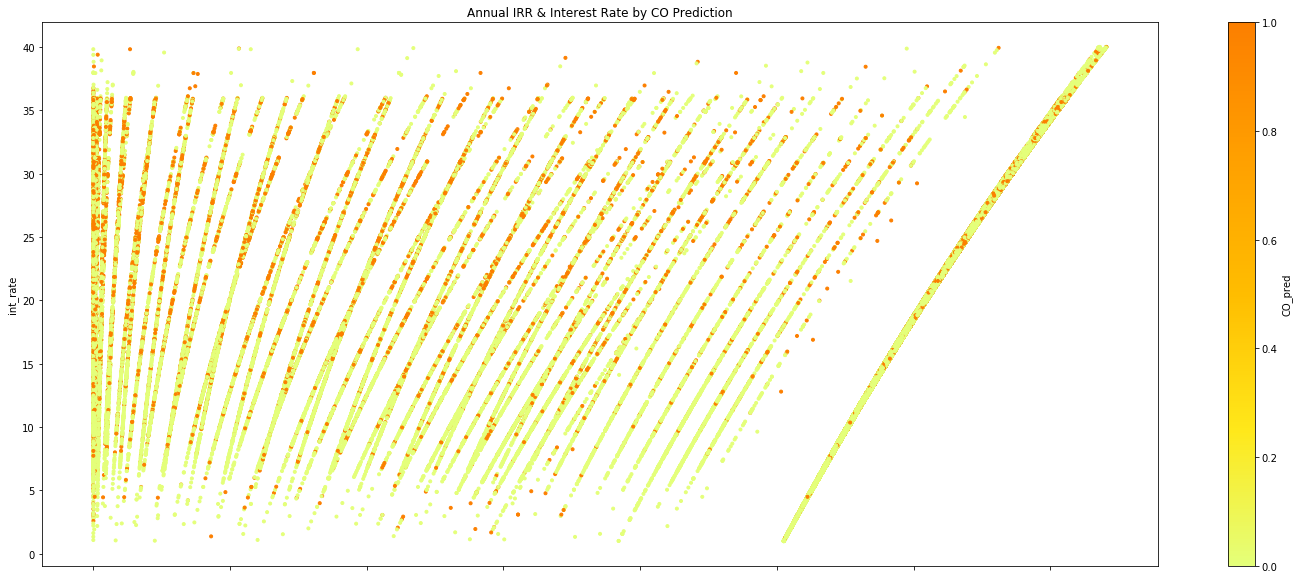

In [101]:
enriched_features.plot.scatter(x= "ann_irr", y= "int_rate", c= "CO_pred", colormap="Wistia", alpha=1, s=9, figsize=(25, 10), title="Annual IRR & Interest Rate by CO Prediction")
plt.xlabel("Annual IRR");

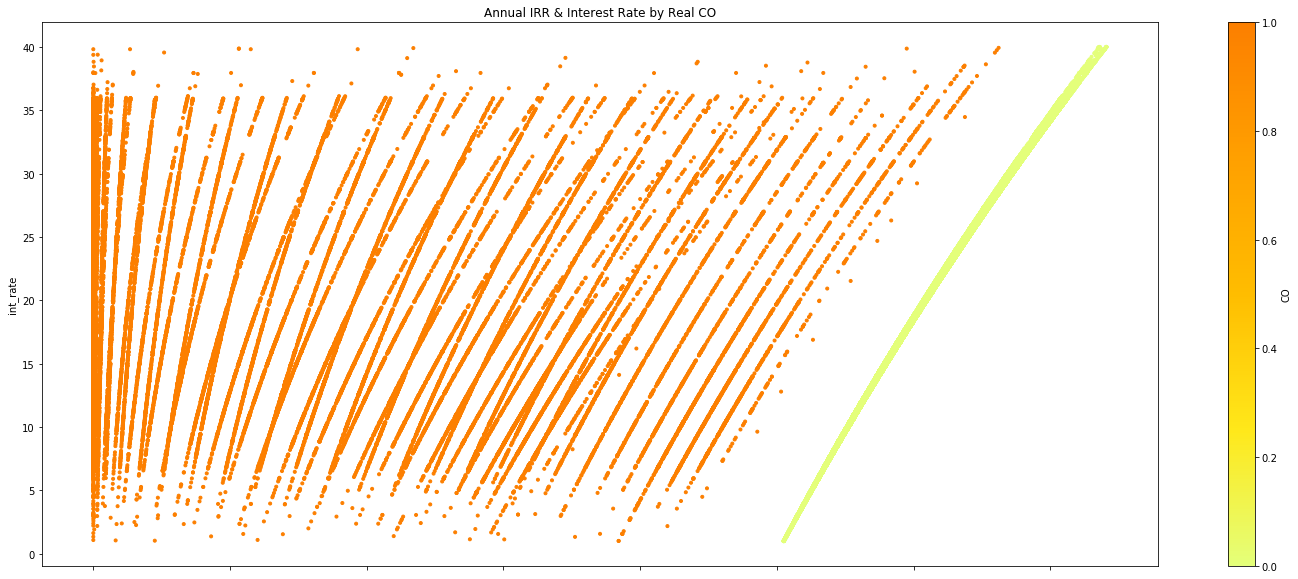

In [106]:
enriched_features['CO'] = (~(enriched_features['co_mob'].isna())).astype(int)
enriched_features.plot.scatter(x= "ann_irr", y= "int_rate", c='CO', colormap="Wistia", alpha=1, s=9, figsize=(25, 10), title="Annual IRR & Interest Rate by Real CO");

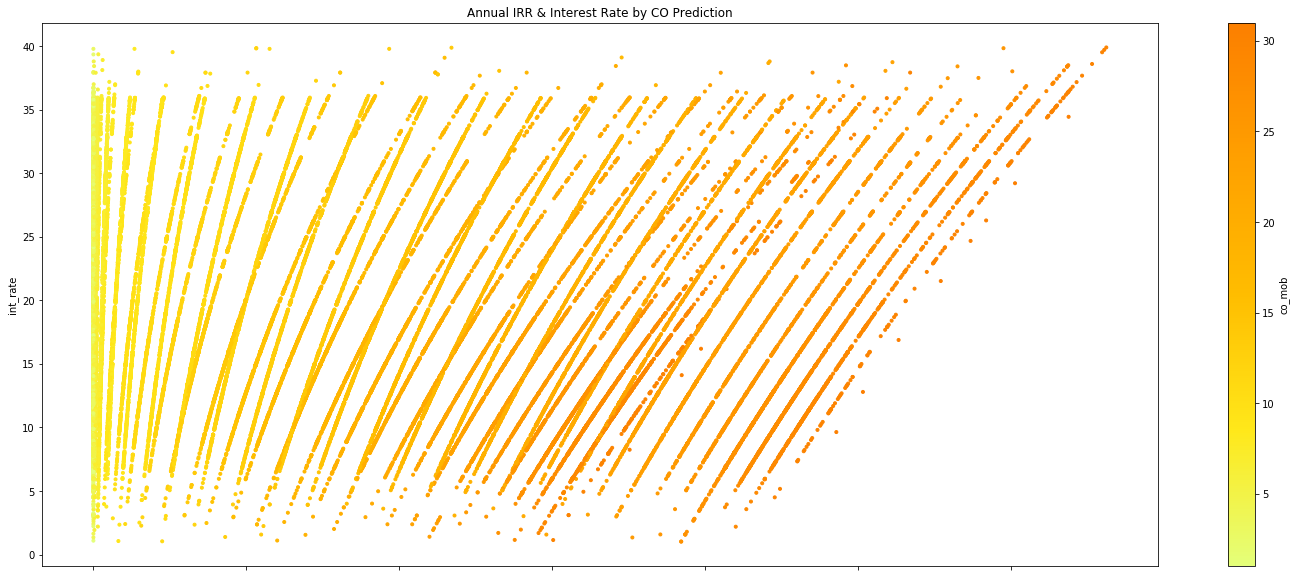

In [105]:
enriched_features.plot.scatter(x= "ann_irr", y= "int_rate", c='co_mob', colormap="Wistia", alpha=1, s=9, figsize=(25, 10), title="Annual IRR & Interest Rate by Real CO Month");

<span style="color:teal">Predicted CO points seem to cluster towards higher interest rates. As the irr decreases, the proportion of CO seems to incread, where the bottom line (yield = -1) is nearly all orange.

Line formation is also interesting- why?
</span>

<font color='navy'>
    Each line represents CO month, where the rightmost line contains the sub-population of borrowers who did not CO at all.<br>
    We have validated this assumption with 2 additional graphs, the first coloring sub-populations by actual CO status, the second coloring the sub-populations by CO mob. <br>
    We can see that in each sub-population of CO mob, as we increase the interest rate, the annual IRR will also increase. This does make sense, as the annual IRR converges to the interest rate in case there was no CO or delay in payments.<br>
    The only exception is the leftmost line, which represents the sub-population who COed before the first payment, then the annual IRR is exactly -1, regardless of the loan's interest rate (as we lost the whole investment).

What is the average IRR for the predicted-CO goup? what is the average IRR for the predicted-non-CO group?

In [98]:
print("Average IRR for predicted CO group:")
enriched_features.loc[enriched_features["CO_pred"]==1,'ann_irr'].mean()

Average IRR for predicted CO group:


0.0740165268311823

In [99]:
print("Average IRR for predicted non-CO group:")
enriched_features.loc[enriched_features["CO_pred"]==0,'ann_irr'].mean()

Average IRR for predicted non-CO group:


0.0991081564286732

_Remark_. The average IRR is usually not the best estimator for the IRR of a portfolio, as it can be very different from the total IRR. However, considering averages allows us to apply statistical tool, which gives way for analyses; specifically, using linear regression.

_Another remark_. A beter approximation for the IRR of a portfolio can be achieved using a weighted average instead of an ordinary average (e.g. weigheted by the loan's amount). Feel free to try to adapt the current method for weighted averages.

## Statistical test for comparing averages

As explained in the notion page, the averages of two population of a sample can be compared using infrernce from a linear regression model. Indeed, the averages of the two subsets are different if and only if the slope of the regression line $y\sim mx+n$, where $x=1$ on one subset and $0$ otherwise, is non-zero.

Use the [statsmodels.api.OLS](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html) package in order to create a regression model, with IRR as the dependent variable and a binary variable describing membership to either of the CO-groups as the independent variable. 

In [138]:
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant

In [140]:
ols_model = OLS(enriched_features['ann_irr'], add_constant(enriched_features['CO']))

In [141]:
results = ols_model.fit();

In [142]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ann_irr   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 1.442e+06
Date:                Mon, 18 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:56:37   Log-Likelihood:             3.0365e+05
No. Observations:              466086   AIC:                        -6.073e+05
Df Residuals:                  466084   BIC:                        -6.073e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1631      0.000    845.052      0.000       0.163       0.163
CO            -0.8018      0.001  -1200.684      0.000      -0.803      -0.800
==============================================================================
Omnibus:                   102775.409   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           496036.747
Skew:                           0.994   Prob(JB):                         0.00
Kurtosis:                       7.647   Cond. No.                         3.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
results.params

const    0.163088
CO      -0.801753
dtype: float64

Create a sctterplot of the dependent vs the independent variable of the model, and add the regression line to the plot. In addition, it is recommended that yoy add lines indicating the confidence region of your regression line (you can use the [seaborn.regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html) package or some of the additional functionality of `statsmodels.api.OLS` package).

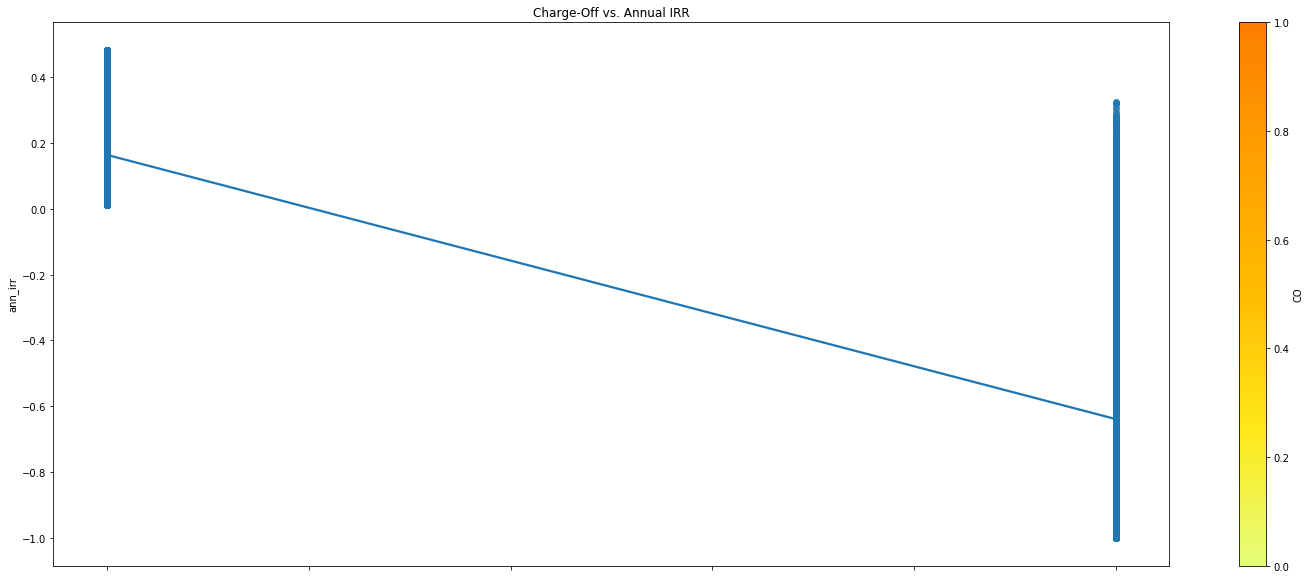

In [127]:
enriched_features.plot.scatter(x= "CO", y= "ann_irr", c='CO', colormap="Wistia", alpha=1, s=3, figsize=(25, 10), title="Charge-Off vs. Annual IRR")
sns.regplot(x="CO", y="ann_irr", data=enriched_features);

In [144]:
results.fittedvalues.value_counts()

 0.163088    427153
-0.638665     38933
dtype: int64

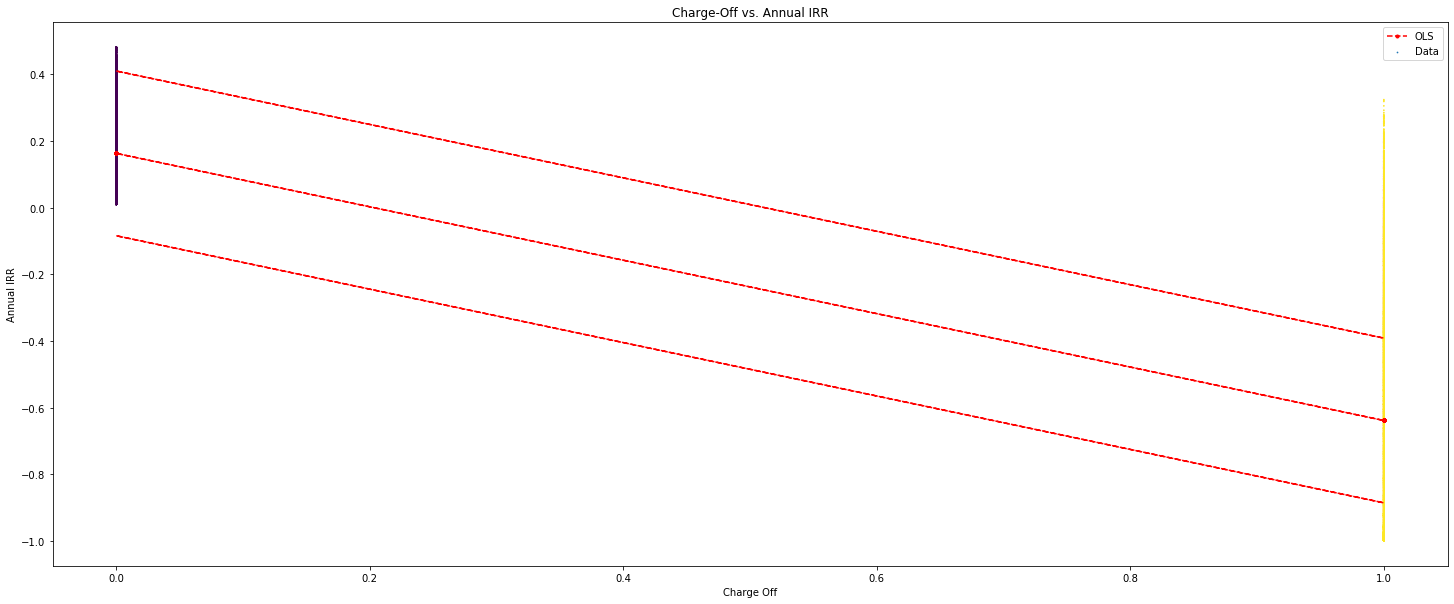

In [145]:
pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(25, 10))
ax.set_title("Charge-Off vs. Annual IRR")
ax.set_xlabel("Charge Off")
ax.set_ylabel("Annual IRR")

ax.scatter(x=enriched_features['CO'], y=enriched_features['ann_irr'], c=enriched_features['CO'], alpha=1, s=0.5, label="Data")

ax.plot(enriched_features['CO'], results.fittedvalues, "r--.", label="OLS")
ax.plot(enriched_features['CO'], iv_u, "r--")
ax.plot(enriched_features['CO'], iv_l, "r--")
ax.legend(loc="best");

Is the slope of the regression line significantly different from zero? What can you conclude from this result regarding the difference in risk levels between the two groups?

<font color = 'navy'>
    We will test the below hypothesis to determine whether the slope is significantly different from 0
$H_0: m = 0 \\
H_1: m \neq 0
$

In [156]:
from scipy.stats import ttest_ind

In [148]:
_, p_val = ttest_ind(enriched_features[enriched_features["CO"]==1]["ann_irr"], enriched_features[enriched_features["CO"]==0]["ann_irr"], equal_var=False)

In [161]:
print(p_val)
print(enriched_features[enriched_features["CO"]==1]["ann_irr"].mean())
print(enriched_features[enriched_features["CO"]==0]["ann_irr"].mean())

0.0
-0.6386650546096022
0.16308770562401032


<font color = 'navy'>
    The slope is (statisticaly speaking) significantly different from 0, as our statistical test resulted in a p value smaller than $\alpha$.<br>
    The difference in the two means is also very significant, being ~80%

<span style="color:teal">
The two means are different to a very high degree of significance. However, the confidence interval is very wide, indicating a large margin of error, and the actual difference between the means is very small (under 0.3%), so it is unclear whether there is a good enough separation between the groups.
</span>

### Controlling for interest rate

To check whether the difference in risk between the two groups is explained by the different interest rate, fit a new regression model, now with both model score and interest rate as covariates, and check whether the risk level is different between the two groups when controlling for interest rate.

Create two overlaying scatterplots of IRR vs interest rate, according to the different groups, and add the regression line associated to each group the the corresponding scatterplot. Can you detect a visible difference between the two groups?

<span style="color:teal">
    Some difference, but very slight
    </span>

Check the model's results summary to see if the coefficient related to model-score group is significantly different from zero.

What is your conclusion? Is the risk level between the two groups different when interest rate is controlled for?

Can you rely on the PPCC21 model score as an indicator for risk level?

<span style="color:teal">
        The model significantly separates between the two risk groups, but the separation seems to be ineffective
</span>

## Comparing proportions of the different groups in Raleigh and Lubbock

In order to compare the risk levels of the activated populations in Raleigh and Lubbock, start by adding a model prediction to each activated loan of the two tables. You have already added the necessary TU feature to the tables in a previous section, so all that's left is to run the model on each of them get the necessary predictions, and add these as a column to the table.

Run a proprotions test in order to check if the proportion of risky borrowers is significantly larger in Raleigh than in Lubbock.

What do you conclude regarding the risk level of the activated population in each town?

<span style="color:teal"> 
    We cannot reject the null hypothesis that the proportion of risky borrowers in Raleigh is smaller or equal to the one in Lubbock.
    </span>

# Analysis using current payments

One more strategy for analyzing the risk level of a current portfolio is to analyze the number of late payments in a given period. Generally speaking, since loans with late or partial payments are indicative of the borrower's ability to repay the loan, we consider portfolios with higher proportions of such payments as being riskier.

We'll call a loan late at mob i if its payment at this month is less then 95% of the amount that was supposed to be paid on that month.

We have payments reports for the first six months of each loan issued before 2020 in Raleigh and Lubbock. These are available in the following directories:

In [ ]:
raleigh_current_pmts= pd.read_parquet(os.path.join(ASSIGNMENT2_DATA, "payment_report_RL.parquet"))
lubbock_current_pmts= pd.read_parquet(os.path.join(ASSIGNMENT2_DATA, "payment_report_LB.parquet"))

The payments file come in the form of tradelines; that is- each row describe a single payment made towards a give loan,

Create new tables in which every loan id appears in a unique line, along with its features (`int_rate`, `loan_amnt`, `monthly_pmt` etc), and there is a column `pmt_{i}` for each `i`=1,..,6 which contains the payment made at mob `i`. Use the [pandas.DataFrame.pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) method in order to perform the last part.

Add a column to the dataframes above, containing the number of late months of the corresponding loan (that is- the number of months in which the amount paid is less then 95% of the monthly payment.

For each number n=0,..,6 compute the percentage of loans each of the above table that are late by n months. Plot these distributions (e.g. using the [seaborn.countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html) function). Can you detect a visible difference between the two tables?

So we've seen by now that there is a detectable difference between the frequencies of late payments in the two towns, but how do the two of them compare with the general population?

In order to get a benchmark for the number of late payments at each mob in the general population, we'll also draw payment reports from the general population. To this end, you will find payments reports for the period 2017-04--2020-12, taken from the Upgrade platform, in the following path:

In [ ]:
upgrade_payments = pd.read_parquet(os.path.join(ASSIGNMENT2_DATA, "upgrade2020_payments.parquet"))

Note that these files are also formatted as tradelines, with the amount paid at each month recorded in the column `paid`, and should be reformatted so that all payments of a given loan appear in a single line using the `pandas.DataFrame.pivot` method. Do this now- create a new table in which every loan appears in a single line, with a column for each mob containing the amount paid at that mob.
Additionally, add the following features of the loan: `loan_amnt`,`original_interest_rate`, `term_in_months` and `last_reported_mob`.

As you may have noted, the monthly payment of each loan is missing from the table above. Please compute it using the [numpy_financial.pmt](https://numpy.org/numpy-financial/dev/pmt.html) function.

Now, repeat the analysis you done above in order to compute the percentages of late loans by month in the general population and compare them to your results from Raleigh and Luboock. Which of the two seem closer to the population banchmark?

Perform a statistical test which will validate this observation. That is- compare the proportion of loans late by n months in each of the towns with that of the general population and test which of these are significantly different from the general population. Note that you are comparing 6 subsets of the same sample, so this may require some manipulation of your alpha values.